In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
!nvidia-smi

Sat Jun 12 14:01:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Drive

In [ ]:
# Point Colaboratory to your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls ./gdrive/MyDrive/HDA2021/Data/

doing_the_dishes.wav  full_list.txt    samplesOrigSR.pickle
dude_miaowing.wav     pink_noise.wav   speech_commands_v0.02.tar.gz
exercise_bike.wav     running_tap.wav  white_noise.wav


In [ ]:
# import libraries

# import tarfile
import os

from scipy.io.wavfile import read as read_wav
import librosa # librosa.load could be slower (conversion to float and resampling)
# but offers more tools

import pandas as pd
import numpy as np

# from scipy.fftpack import dct

import hashlib
import re

# import cv2

import matplotlib.pyplot as plt
import librosa.display as ldisp
import IPython.display as ipd
# from sklearn import * # da decidere cosa
# import tensorflow as tf
# from tensorflow import keras

In [ ]:
# parameters

DRIVE_BASE_FOLDER = './gdrive/MyDrive/HDA2021/Data/' # SLURM path?
LOCAL_BASE_FOLDER = '/content/Data/'

SAMPLE_RATE = 16000
FRAME_SIZE = 0.025 #0.032
FRAME_STRIDE = 0.010 #0.016 # FRAME_SIZE - FRAME_STRIDE seconds overlap
FINAL_LEN = 15599 # 16000*0.01 * 29 + 16000*0.025
N_MELS = 40

## Extract and save the data

Read README.md

Path example:
./Path/To/UncompressedData/follow/a95dbfd4_nohash_0.wav

In [ ]:
# count: 105878
#!tar -tf "./gdrive/MyDrive/HDA2021/Data/speech_commands_v0.02.tar.gz" | wc -l

In [ ]:
# list archive files
#!tar -tvf "./gdrive/MyDrive/HDA2021/Data/speech_commands_v0.02.tar.gz" &> "./gdrive/MyDrive/HDA2021/Data/filesList.txt"

In [ ]:
# extract archive files
#!tar -xf "./gdrive/MyDrive/HDA2021/Data/speech_commands_v0.02.tar.gz" --directory "./Data/UncompressedData"

In [ ]:
# copy uncompressed data to drive
#!cp -avr ./Data/UncompressedData/ ./gdrive/MyDrive/HDA2021/Data/

In [ ]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1
def which_set_df(base_name, validation_percentage=20, testing_percentage=20):
  """Determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'testing'
  else:
    result = 'training'
  return result

In [ ]:
df['TVT'] = df.speakerID.map(which_set_df)

In [ ]:
df[df.TVT == 'training'].label.value_counts(normalize=True) * 100

zero        3.827908
yes         3.792016
five        3.774851
seven       3.753004
no          3.742080
nine        3.720233
one         3.696826
six         3.684342
on          3.679660
two         3.676539
down        3.674979
go          3.671858
stop        3.648450
eight       3.601635
left        3.557941
right       3.537655
off         3.501763
four        3.492400
three       3.473674
up          3.450267
dog         2.055179
marvin      2.033332
wow         2.030211
house       2.025530
bird        1.947505
cat         1.941263
sheila      1.900690
happy       1.889766
bed         1.883524
tree        1.643207
backward    1.596392
learn       1.548017
follow      1.533972
visual      1.527730
forward     1.485597
Name: label, dtype: float64

In [ ]:
df[df.TVT == 'validation'].label.value_counts(normalize=True) * 100

yes         3.888306
five        3.869246
no          3.864481
zero        3.821595
seven       3.778710
down        3.731059
off         3.692938
up          3.692938
go          3.688173
four        3.683408
six         3.678643
two         3.664348
nine        3.640522
left        3.640522
three       3.626227
stop        3.626227
right       3.616697
on          3.616697
eight       3.592871
one         3.573811
happy       2.010864
bed         2.001334
dog         1.987039
sheila      1.982274
wow         1.901268
marvin      1.858382
house       1.839321
cat         1.782140
bird        1.748785
tree        1.677309
backward    1.515296
follow      1.448585
visual      1.448585
forward     1.434290
learn       1.377109
Name: label, dtype: float64

In [ ]:
df[df.TVT == 'testing'].label.value_counts(normalize=True) * 100

five        3.954530
seven       3.853379
yes         3.843745
zero        3.838929
nine        3.785945
down        3.752228
stop        3.723327
one         3.713694
left        3.646260
two         3.636626
go          3.626993
right       3.622176
three       3.564376
up          3.549925
no          3.525842
on          3.506575
six         3.501758
off         3.496941
eight       3.492125
four        3.453591
bird        2.162709
house       2.066374
wow         2.037474
happy       2.027841
cat         1.989307
marvin      1.960407
dog         1.897789
sheila      1.868889
bed         1.864072
tree        1.705120
backward    1.555802
visual      1.488368
forward     1.464284
learn       1.416117
follow      1.406483
Name: label, dtype: float64

In [ ]:
mostFreqLabels = df.label.value_counts()[df.label.value_counts(normalize=True) > 0.03].index

In [ ]:
dfFreq = df[df.label.map(lambda x: x in mostFreqLabels)]

NameError: ignored

In [ ]:
dfFreq.shape

(77454, 5)

In [ ]:
trainFreq = dfFreq[dfFreq.TVT == 'training'][['audio', 'label']]
validFreq = dfFreq[dfFreq.TVT == 'validation'][['audio', 'label']]
testFreq = dfFreq[dfFreq.TVT == 'testing'][['audio', 'label']]

In [ ]:
trainFreq.head()

,audio,label
five_f5c3de1b_1,"[6155, 6530, 6628, 6458, 6160, 6199, 6704, 644...",five
five_42ccb57a_4,"[-202, -464, -337, -306, -367, -360, -420, -42...",five
five_8134f43f_1,"[-58, -205, -271, -161, -54, -13, 12, 80, 3, -...",five
five_ac9dee0e_2,"[1, -1, -3, -4, -1, 0, 1, 1, 0, 1, 3, 3, 1, 1,...",five
five_8dd788d8_1,"[-54, -44, -53, -81, -107, -98, -53, -23, -51,...",five


### Librosa (fail)

In [ ]:
# librosa "parser"

# tar = tarfile.open(DATA_BASE_FOLDER+"speech_commands_v0.02.tar.gz", "r:gz")

# data = {}
# exceptions = []

# for member in tar.getmembers():
#     f = tar.extractfile(member)
#     if f is not None:
#         # add kw_ID_utteranceNumber:(class,(audioArray, sr)) to data dictionary
#         temp = member.name.split('/')
#         try:
#             temp[2] = temp[2].split('_')
#             data[temp[1]+'_'+temp[2][0]+'_'+temp[2][2][:-4]] = (temp[1],librosa.load(f, sr=None)) # sr: sampling rate, by default = 22050
#         except:
#             exceptions.append(member.name)
#             continue

In [ ]:
# parsed with librosa to df
#df = pd.DataFrame.from_dict(data, orient='index', columns=['class', 'sample, sr'])

### scipy.io (win)

In [ ]:
# read_wav test
#read_wav(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/bed/004ae714_nohash_1.wav')) # no 2

In [ ]:
# # some stats preparation (extract the dataset locally first)

# lt = []
# mt = []
# for folder in os.listdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/')):
#     if os.path.isdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder)):
#         for filename in os.listdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder)):
#             if filename.endswith('.wav'):
#                 temp = read_wav(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder, filename))
#                 if len(temp[1]) < 16000:
#                     lt.append((os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder, filename), len(temp[1]) ))#, temp[0]))
#                 if len(temp[1]) > 16000:
#                     mt.append((os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder, filename), len(temp[1]) ))#, temp[0]))

In [ ]:
# # audio longer than 1 second

# for i in range(len(mt)):
#     print(mt[i], f'{mt[i][1]/16000:20.3f} seconds')

In [ ]:
# # final parser with scipy.io (extract the dataset locally first)

# data = {}
# for folder in os.listdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/')):
#     if os.path.isdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder)):
#         for filename in os.listdir(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder)):
#             if filename.endswith('.wav'):
#                 temp = read_wav(os.path.join(LOCAL_BASE_FOLDER, 'UncompressedData/', folder, filename))
#                 if len(temp[1]) <= 16000: # 004ae714_nohash_1.wav
#                     speakerID = filename.split('_')[0]
#                     uttN = int(filename.split('_')[2][:-4])+1
#                     data[folder + '_' + speakerID + '_' + str(uttN)] = (folder, temp[1], speakerID, uttN+1)

In [ ]:
# parsed with scipy.io to df
#df = pd.DataFrame.from_dict(data, orient='index', columns=['class', 'samplE', 'speakerID', 'uttN'])

In [ ]:
# save df to pickle
#df.to_pickle(LOCAL_BASE_FOLDER+'samplesOrigSR.pickle')

In [ ]:
# !wc -c ./Data/samplesOrigSR.pickle # !ls -l shows a little more
!wc -c ./gdrive/MyDrive/HDA2021/Data/samplesOrigSR.pickle # !ls -l shows a little more

3330616988 ./gdrive/MyDrive/HDA2021/Data/samplesOrigSR.pickle


## Load dataset from pickle

In [ ]:
def which_set(base_name, validation_percentage, testing_percentage):
  """Determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """
  # base_name = os.path.basename(filename) # Path/To/BASENAME == Path/To/FILE.EST
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name)
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'testing'
  else:
    result = 'training'
  return result

In [ ]:
# import df from pickle
df = pd.read_pickle(DRIVE_BASE_FOLDER+'samplesOrigSR.pickle')
df.columns = ['label', 'audio', 'speakerID', 'uttN']

In [ ]:
df.shape # validation/test

(105829, 4)

In [ ]:
#LastComparison = [dfInDrive.iloc[i,1] == dfIn.iloc[i,1] for i in range(dfInDrive.shape[0])]

In [ ]:
#l = [LastComparison[i].all() for i in range(len(LastComparison))]

In [ ]:
#del LastComparison

## EDA

In [ ]:
print(df.shape) # (105829, 4)

In [ ]:
df.head()

The sampling rate is 16000 for all the samples.

In [ ]:
df['samLength'] = df.audio.apply(len)

In [ ]:
df[df.samLength > 2000]

Only 6 are (way) longer than 1 second (roughly 60 and 90 seconds, removed for now).

In [ ]:
# ('/content/Data/UncompressedData/_background_noise_/dude_miaowing.wav', 988891)        61.806 seconds
# ('/content/Data/UncompressedData/_background_noise_/running_tap.wav', 978488)          61.156 seconds
# ('/content/Data/UncompressedData/_background_noise_/pink_noise.wav', 960000)           60.000 seconds
# ('/content/Data/UncompressedData/_background_noise_/doing_the_dishes.wav', 1522930)    95.183 seconds
# ('/content/Data/UncompressedData/_background_noise_/white_noise.wav', 960000)          60.000 seconds
# ('/content/Data/UncompressedData/_background_noise_/exercise_bike.wav', 980062)        61.254 seconds

10435 are shorter than one second.

In [ ]:
th = 15119 # 16000 <-> 1 second = samLength / sr
stats = df.samLength[df.samLength <= th]
stats.describe()

In [ ]:
df.iloc[4,:]

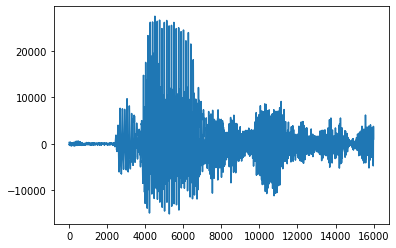

In [ ]:
# time domain
signal = df.audio[4].astype('float32')
plt.plot(signal)

In [ ]:
signal.shape

(16000,)

In [ ]:
juneSignal = trainFreq.audio[4].astype('float32')

In [ ]:
type(juneSignal)

In [ ]:
ipd.Audio(data=juneSignal, rate=SAMPLE_RATE)

## Data preparation

### Pre-emphasis

In [ ]:
pre_emphasis = 0.95
emph_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

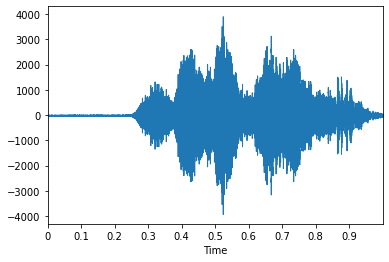

In [ ]:
ldisp.waveplot(emph_signal, sr=SAMPLE_RATE)

In [ ]:
ipd.Audio(data=emph_signal, rate=SAMPLE_RATE)

In [ ]:
FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)

print(f'{FRAME_LEN}, {HOP_LEN}')

400, 160


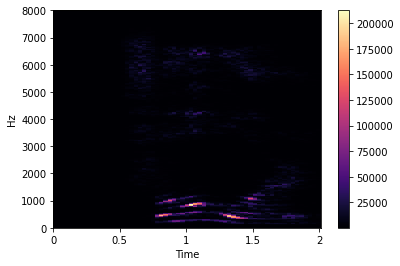

In [ ]:
D = np.abs(librosa.stft(emph_signal, n_fft=FRAME_LEN,  hop_length=HOP_LEN))
librosa.display.specshow(D, sr=SAMPLE_RATE, x_axis='time', y_axis='linear');
plt.colorbar();

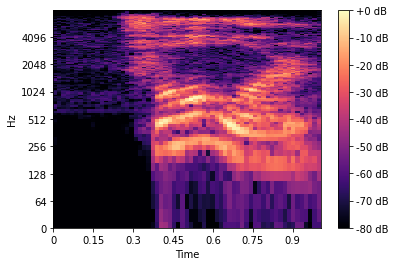

In [ ]:
DB = librosa.amplitude_to_db(D, ref=np.max)
ldisp.specshow(DB, sr=SAMPLE_RATE, hop_length=HOP_LEN, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [ ]:
mel = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=FRAME_LEN, n_mels=N_MELS)
mel

array([[0.0000000e+00, 3.6951047e-03, 7.3902095e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2151540e-04,
        6.0757699e-05, 0.0000000e+00]], dtype=float32)

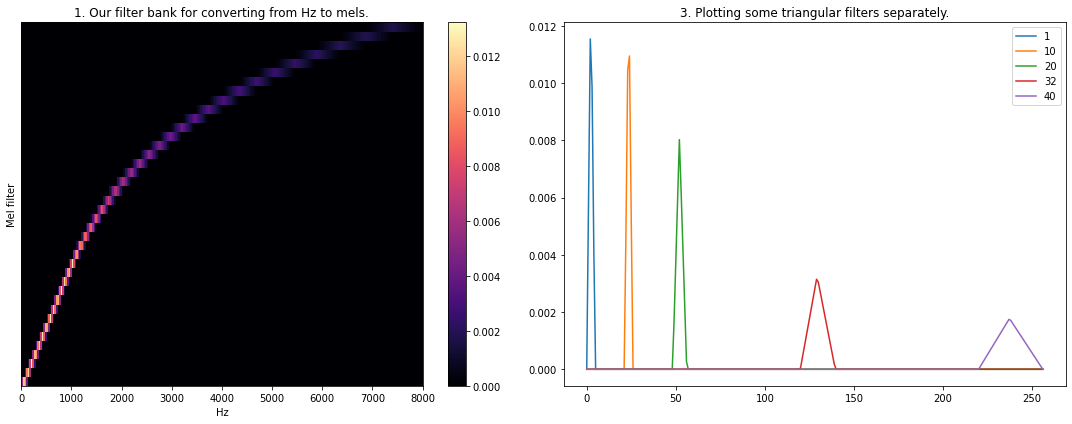

In [ ]:
plt.figure(figsize=(15, 6));

plt.subplot(1, 2, 1);
ldisp.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LEN, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 2, 2);
idxs_to_plot = [0, 9, 19, 31, 39]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

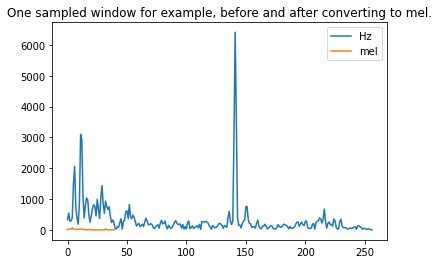

In [ ]:
plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');

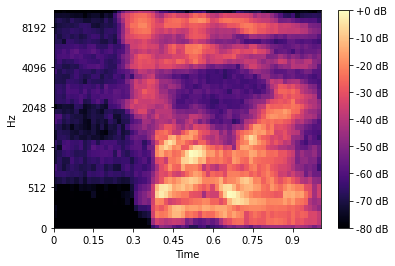

In [ ]:
S = librosa.feature.melspectrogram(emph_signal, sr=SAMPLE_RATE, n_fft=FRAME_LEN,
                                   hop_length=HOP_LEN, n_mels=N_MELS)
S_DB = librosa.power_to_db(S, ref=np.max)
ldisp.specshow(S_DB, sr=SAMPLE_RATE, hop_length=HOP_LEN, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
fft_windows = librosa.stft(emph_signal, n_fft=FRAME_LEN, hop_length=HOP_LEN)
magnitude = np.abs(fft_windows)**2

assert (mel.dot(magnitude) == S).all() # OK

In [ ]:
dfFreq.audio.map(len).describe()

count    77454.000000
mean     15726.476360
std       1085.952908
min       4096.000000
25%      16000.000000
50%      16000.000000
75%      16000.000000
max      16000.000000
Name: audio, dtype: float64

In [ ]:
df.audio.map(len).describe()

count    105829.000000
mean      15694.885268
std        1148.372218
min        3413.000000
25%       16000.000000
50%       16000.000000
75%       16000.000000
max       16000.000000
Name: audio, dtype: float64

In [ ]:
df.audio.map(len).head(10)

dog_f2e59fea_1    16000
dog_f5c3de1b_1    16000
dog_5ab63b0a_4    16000
dog_71f6fed7_1    16000
dog_8134f43f_1    16000
dog_d5cdb23e_1    11605
dog_b544d4fd_2    16000
dog_11321027_1    16000
dog_97f493b9_1    13654
dog_bbbf4fbd_2    16000
Name: audio, dtype: int64

## .py scripts

### read dataset from txt list

#### saveValidTest

In [ ]:
# -*- coding: utf-8 -*-

# import libraries

import os
import time

from scipy.io.wavfile import read as read_wav
import librosa # librosa.load could be slower (conversion to float and resampling)
# but offers more tools

import pandas as pd
import numpy as np

# from scipy.fftpack import dct

# import cv2

import matplotlib.pyplot as plt
import librosa.display as ldisp
import IPython.display as ipd
# from sklearn import * # da decidere cosa
# import tensorflow as tf
# from tensorflow import keras


# parameters

LOCAL_DATA_FOLDER = '/nfsd/hda/DATASETS/Project_1/'
LOCAL_USER_FOLDER = '/nfsd/hda/petrellaal/'

SAMPLE_RATE = 16000
FRAME_SIZE = 0.032
FRAME_STRIDE = 0.016 # FRAME_SIZE - FRAME_STRIDE seconds overlap
N_MELS = 40

# validation

tic = time.time()

data = {}
with open(os.path.join(LOCAL_DATA_FOLDER, 'validation_list.txt')) as f:
    for path in f:
        folder, filename = path.split('/')
        filename = filename[:-1]
        temp = read_wav(os.path.join(LOCAL_DATA_FOLDER, path[:-1]))
        if len(temp[1]) <= 16000: # 004ae714_nohash_1.wav
            speakerID = filename.split('_')[0]
            uttN = int(filename.split('_')[2][:-4])+1
            data[folder + '_' + speakerID + '_' + str(uttN)] = (folder, temp[1], speakerID, uttN+1)

print(f'{len(data)} elements added')
print(f'Dictionary creation: {time.time() - tic}')

tic = time.time()

df = pd.DataFrame.from_dict(data, orient='index', columns=['label', 'samplE', 'speakerID', 'uttN'])

print(f'{df.shape} df created')
print(f'df creation: {time.time() - tic}')

df.to_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_valid.pickle.gz'), 'gzip')

# test

tic = time.time()

data = {}
with open(os.path.join(LOCAL_DATA_FOLDER, 'testing_list.txt')) as f:
    for path in f:
        folder, filename = path.split('/')
        filename = filename[:-1]
        temp = read_wav(os.path.join(LOCAL_DATA_FOLDER, path[:-1]))
        if len(temp[1]) <= 16000: # 004ae714_nohash_1.wav
            speakerID = filename.split('_')[0]
            uttN = int(filename.split('_')[2][:-4])+1
            data[folder + '_' + speakerID + '_' + str(uttN)] = (folder, temp[1], speakerID, uttN+1)

print(f'{len(data)} elements added')
print(f'Dictionary creation: {time.time() - tic}')

tic = time.time()

df = pd.DataFrame.from_dict(data, orient='index', columns=['label', 'samplE', 'speakerID', 'uttN'])

print(f'{df.shape} df created')
print(f'df creation: {time.time() - tic}')

df.to_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_test.pickle.gz'), 'gzip')


#### saveTrain

In [ ]:
# -*- coding: utf-8 -*-

# import libraries

import os
import time

from scipy.io.wavfile import read as read_wav
import librosa # librosa.load could be slower (conversion to float and resampling)
# but offers more tools

import pandas as pd
import numpy as np

# from scipy.fftpack import dct

# import cv2

import matplotlib.pyplot as plt
import librosa.display as ldisp
import IPython.display as ipd
# from sklearn import * # da decidere cosa
# import tensorflow as tf
# from tensorflow import keras


# parameters

LOCAL_DATA_FOLDER = '/nfsd/hda/DATASETS/Project_1/'
LOCAL_USER_FOLDER = '/nfsd/hda/petrellaal/'

SAMPLE_RATE = 16000
FRAME_SIZE = 0.032
FRAME_STRIDE = 0.016 # FRAME_SIZE - FRAME_STRIDE seconds overlap
N_MELS = 40

# train

df = pd.read_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_valid.pickle.gz'), 'gzip')
ignoreSet = set(df.speakerID.unique())

df = pd.read_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_test.pickle.gz'), 'gzip')
ignoreSet.update(df.speakerID.unique())

del df

tic = time.time()

data = {}
exceptions = []

with open(os.path.join(LOCAL_USER_FOLDER, 'full_list.txt')) as f:
    for line in f:
        if line[:2] == './':
            folder = line[2:-2]
        elif line[-5:]=='.wav\n':
            try:
                speakerID, _, uttN = line.split('_')
                uttN = int(uttN[:-5]) + 1
                if speakerID not in ignoreSet:
                    temp = read_wav(os.path.join(LOCAL_DATA_FOLDER, folder, line[:-1]))
                    if len(temp[1]) <= 16000: # 004ae714_nohash_1.wav
                        data[folder + '_' + speakerID + '_' + str(uttN-1)] = (folder, temp[1], speakerID, uttN)
                    else:
                        exceptions.append(line)
            except:
                exceptions.append(line)
                continue

print(f'Dictionary creation: {time.time() - tic} seconds')           
print(f'{len(data)} elements added, and these exceptions found: {exceptions}')

tic = time.time()

df = pd.DataFrame.from_dict(data, orient='index', columns=['label', 'samplE', 'speakerID', 'uttN'])

print(f'{df.shape} df created')
print(f'df creation: {time.time() - tic} seconds')

df.to_hdf(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_train.h5'), '/data/d1')


#### checkDims

In [ ]:
# -*- coding: utf-8 -*-

# import libraries

import os
import time

from scipy.io.wavfile import read as read_wav
import librosa # librosa.load could be slower (conversion to float and resampling)
# but offers more tools

import pandas as pd
import numpy as np

# from scipy.fftpack import dct

# import cv2

import matplotlib.pyplot as plt
import librosa.display as ldisp
import IPython.display as ipd
# from sklearn import * # da decidere cosa
# import tensorflow as tf
# from tensorflow import keras


# parameters

LOCAL_DATA_FOLDER = '/nfsd/hda/DATASETS/Project_1/'
LOCAL_USER_FOLDER = '/nfsd/hda/petrellaal/'

SAMPLE_RATE = 16000
FRAME_SIZE = 0.032
FRAME_STRIDE = 0.016 # FRAME_SIZE - FRAME_STRIDE seconds overlap
N_MELS = 40

valid_df = pd.read_pickle('/nfsd/hda/petrellaal/audioOrigSR_valid.pickle.gz', 'gzip')
valid_df.columns = ['label', 'audio', 'speakerID', 'uttN']
print(valid_df.shape)

test_df = pd.read_pickle('/nfsd/hda/petrellaal/audioOrigSR_test.pickle.gz', 'gzip')
test_df.columns = ['label', 'audio', 'speakerID', 'uttN']
print(test_df.shape)

# train

df = pd.read_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_valid.pickle.gz'), 'gzip')
ignoreSet = set(df.speakerID.unique())

df = pd.read_pickle(os.path.join(LOCAL_USER_FOLDER, 'audioOrigSR_test.pickle.gz'), 'gzip')
ignoreSet.update(df.speakerID.unique())

del df

tic = time.time()

data = {}
exceptions = []

with open(os.path.join(LOCAL_USER_FOLDER, 'full_list.txt')) as f:
    for line in f:
        if line[:2] == './':
            folder = line[2:-2]
        elif line[-5:]=='.wav\n':
            try:
                speakerID, _, uttN = line.split('_')
                uttN = int(uttN[:-5]) + 1
                if speakerID not in ignoreSet:
                    temp = read_wav(os.path.join(LOCAL_DATA_FOLDER, folder, line[:-1]))
                    if len(temp[1]) <= 16000: # 004ae714_nohash_1.wav
                        data[folder + '_' + speakerID + '_' + str(uttN-1)] = (folder, temp[1], speakerID, uttN)
                    else:
                        exceptions.append(line)
            except:
                exceptions.append(line)
                continue

print(f'Dictionary creation: {time.time() - tic} seconds')           
print(f'{len(data)} elements added, and these exceptions found: {exceptions}')

tic = time.time()

df = pd.DataFrame.from_dict(data, orient='index', columns=['label', 'samplE', 'speakerID', 'uttN'])

print(f'{df.shape} df created')
print(f'df creation: {time.time() - tic} seconds')


# Load parsed data

In [ ]:
# Point Colaboratory to your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls ./gdrive/MyDrive/HDA2021/Data/

doing_the_dishes.wav  samplesOrigSR.pickle	    trainNoise13.pickle
dude_miaowing.wav     speech_commands_v0.02.tar.gz  trainReady13.pickle
exercise_bike.wav     test16.pickle		    valid16.pickle
full_list.txt	      testNoise13.pickle	    validNoise13.pickle
pink_noise.wav	      testReady13.pickle	    validReady13.pickle
running_tap.wav       train16.pickle		    white_noise.wav


In [ ]:
# import libraries

# import tarfile
import os

from scipy.io.wavfile import read as read_wav
import librosa # librosa.load could be slower (conversion to float and resampling)
# but offers more tools

import numpy as np
import pandas as pd

# from scipy.fftpack import dct

import hashlib
import re

# import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display as ldisp
import IPython.display as ipd

# import tensorflow as tf
import keras
from keras.layers import Input, Add, Conv2D, Conv2DTranspose, BatchNormalization, LSTM, Dense, Flatten, Reshape, MaxPool2D, AveragePooling2D, Activation
from keras.models import Model, Sequential
# from keras.optimizers import Adam
# from keras.losses import CategoricalCrossentropy

from sklearn import preprocessing

# import os
# import sys

import time

In [ ]:
# folders

DRIVE_BASE_FOLDER = './gdrive/MyDrive/HDA2021/Data/'
LOCAL_BASE_FOLDER = '/content/Data/'

## Complete df

In [ ]:
# import df from pickle
df = pd.read_pickle(DRIVE_BASE_FOLDER + 'samplesOrigSR.pickle')
df.columns = ['label', 'audio', 'speakerID', 'uttN']
df.label.unique()

array(['dog', 'house', 'five', 'bed', 'cat', 'three', 'stop', 'eight',
       'up', 'bird', 'two', 'yes', 'six', 'visual', 'left', 'backward',
       'on', 'go', 'sheila', 'happy', 'marvin', 'wow', 'nine', 'one',
       'no', 'zero', 'seven', 'learn', 'follow', 'off', 'right', 'tree',
       'down', 'four', 'forward'], dtype=object)

In [ ]:
df.shape

(105829, 4)

## Noise

In [ ]:
def create_noise_df(n_per_label, length=15119):
    
    N_bike_df = pd.DataFrame()
    N_bike, _ = librosa.load(DRIVE_BASE_FOLDER+'exercise_bike.wav', sr=None)
    cuts = []
    sample_length = len(N_bike)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_bike[idx : idx + length])
    N_bike_df['audio'] = cuts
    N_bike_df['label'] = 'N_bike'

    N_dishes_df = pd.DataFrame()
    N_dishes, _ = librosa.load(DRIVE_BASE_FOLDER+'doing_the_dishes.wav', sr=None)
    cuts = []
    sample_length = len(N_dishes)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_dishes[idx : idx + length])
    N_dishes_df['audio'] = cuts
    N_dishes_df['label'] = 'N_dishes'

    N_miaow_df = pd.DataFrame()
    N_miaow, _ = librosa.load(DRIVE_BASE_FOLDER+'dude_miaowing.wav', sr=None)
    cuts = []
    sample_length = len(N_miaow)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_miaow[idx : idx + length])
    N_miaow_df['audio'] = cuts
    N_miaow_df['label'] = 'N_miaow'

    N_pink_df = pd.DataFrame()
    N_pink, _ = librosa.load(DRIVE_BASE_FOLDER+'pink_noise.wav', sr=None)
    cuts = []
    sample_length = len(N_pink)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_pink[idx : idx + length])
    N_pink_df['audio'] = cuts
    N_pink_df['label'] = 'N_pink'
    
    N_tap_df = pd.DataFrame()
    N_tap, _ = librosa.load(DRIVE_BASE_FOLDER+'running_tap.wav', sr=None)
    cuts = []
    sample_length = len(N_tap)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_tap[idx : idx + length])
    N_tap_df['audio'] = cuts
    N_tap_df['label'] = 'N_tap'

    N_white_df = pd.DataFrame()
    N_white, _ = librosa.load(DRIVE_BASE_FOLDER+'white_noise.wav', sr=None)
    cuts = []
    sample_length = len(N_white)
    print(sample_length, flush=True)
    for i in range(n_per_label):
        idx = np.random.randint(0, sample_length - length + 1)
        cuts.append(N_white[idx : idx + length])
    N_white_df['audio'] = cuts
    N_white_df['label'] = 'N_white'
    
    return N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df

In [ ]:
# N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df = create_noise_df(n_per_label=385, length=15119) # 3850*60% / 6
# trainNoise = pd.concat([N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df], axis=0)
# trainNoise.to_pickle(DRIVE_BASE_FOLDER+'trainNoise13.pickle')
trainNoise = pd.read_pickle(DRIVE_BASE_FOLDER+'trainNoise13.pickle')

In [ ]:
# N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df = create_noise_df(n_per_label=128, length=15119) # 3850*20% / 6
# validNoise = pd.concat([N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df], axis=0)
# validNoise.to_pickle(DRIVE_BASE_FOLDER+'validNoise13.pickle')
validNoise = pd.read_pickle(DRIVE_BASE_FOLDER+'validNoise13.pickle')

In [ ]:
# N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df = create_noise_df(n_per_label=128, length=15119) # 3850*20% / 6
# testNoise = pd.concat([N_bike_df, N_dishes_df, N_miaow_df, N_pink_df, N_tap_df, N_white_df], axis=0)
# testNoise.to_pickle(DRIVE_BASE_FOLDER+'testNoise13.pickle')
testNoise = pd.read_pickle(DRIVE_BASE_FOLDER+'testNoise13.pickle')

## Training-Validation-Testing split

Probable original train-valid-test proportion: 60-20-20.
```
/nfsd/hda/DATASETS/Project_1$ wc -l validation_list.txt
9981 validation_list.txt

/nfsd/hda/DATASETS/Project_1$ wc -l testing_list.txt
11005 testing_list.txt
```

In [ ]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1
def which_set_df(base_name, validation_percentage=20, testing_percentage=20):
  """Determines which data partition the file should belong to.

  We want to keep files in the same training, validation, or testing sets even
  if new ones are added over time. This makes it less likely that testing
  samples will accidentally be reused in training when long runs are restarted
  for example. To keep this stability, a hash of the filename is taken and used
  to determine which set it should belong to. This determination only depends on
  the name and the set proportions, so it won't change as other files are added.

  It's also useful to associate particular files as related (for example words
  spoken by the same person), so anything after '_nohash_' in a filename is
  ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
  'bobby_nohash_1.wav' are always in the same set, for example.

  Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

  Returns:
    String, one of 'training', 'validation', or 'testing'.
  """
  # We want to ignore anything after '_nohash_' in the file name when
  # deciding which set to put a wav in, so the data set creator has a way of
  # grouping wavs that are close variations of each other.
  hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')
  # This looks a bit magical, but we need to decide whether this file should
  # go into the training, testing, or validation sets, and we want to keep
  # existing files in the same set even if more files are subsequently
  # added.
  # To do that, we need a stable way of deciding based on just the file name
  # itself, so we do a hash of that and then use that to generate a
  # probability value that we use to assign it.
  hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
  percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
  if percentage_hash < validation_percentage:
    result = 'validation'
  elif percentage_hash < (testing_percentage + validation_percentage):
    result = 'testing'
  else:
    result = 'training'
  return result

In [ ]:
df['TVT'] = df.speakerID.map(which_set_df)

In [ ]:
df.label.value_counts()

zero        4052
five        4052
yes         4044
seven       3998
no          3941
nine        3934
down        3917
one         3890
two         3880
go          3880
stop        3872
six         3860
on          3845
left        3801
eight       3787
right       3778
off         3745
four        3728
three       3727
up          3723
dog         2128
wow         2123
house       2113
marvin      2100
bird        2064
happy       2054
cat         2031
sheila      2022
bed         2014
tree        1759
backward    1664
visual      1592
follow      1579
learn       1575
forward     1557
Name: label, dtype: int64

In [ ]:
df[df.TVT == 'training'].label.value_counts(normalize=True) * 100

zero        3.827908
yes         3.792016
five        3.774851
seven       3.753004
no          3.742080
nine        3.720233
one         3.696826
six         3.684342
on          3.679660
two         3.676539
down        3.674979
go          3.671858
stop        3.648450
eight       3.601635
left        3.557941
right       3.537655
off         3.501763
four        3.492400
three       3.473674
up          3.450267
dog         2.055179
marvin      2.033332
wow         2.030211
house       2.025530
bird        1.947505
cat         1.941263
sheila      1.900690
happy       1.889766
bed         1.883524
tree        1.643207
backward    1.596392
learn       1.548017
follow      1.533972
visual      1.527730
forward     1.485597
Name: label, dtype: float64

In [ ]:
df[df.TVT == 'validation'].label.value_counts(normalize=True) * 100

yes         3.888306
five        3.869246
no          3.864481
zero        3.821595
seven       3.778710
down        3.731059
up          3.692938
off         3.692938
go          3.688173
four        3.683408
six         3.678643
two         3.664348
nine        3.640522
left        3.640522
three       3.626227
stop        3.626227
right       3.616697
on          3.616697
eight       3.592871
one         3.573811
happy       2.010864
bed         2.001334
dog         1.987039
sheila      1.982274
wow         1.901268
marvin      1.858382
house       1.839321
cat         1.782140
bird        1.748785
tree        1.677309
backward    1.515296
visual      1.448585
follow      1.448585
forward     1.434290
learn       1.377109
Name: label, dtype: float64

In [ ]:
df[df.TVT == 'testing'].label.value_counts(normalize=True) * 100

five        3.954530
seven       3.853379
yes         3.843745
zero        3.838929
nine        3.785945
down        3.752228
stop        3.723327
one         3.713694
left        3.646260
two         3.636626
go          3.626993
right       3.622176
three       3.564376
up          3.549925
no          3.525842
on          3.506575
six         3.501758
off         3.496941
eight       3.492125
four        3.453591
bird        2.162709
house       2.066374
wow         2.037474
happy       2.027841
cat         1.989307
marvin      1.960407
dog         1.897789
sheila      1.868889
bed         1.864072
tree        1.705120
backward    1.555802
visual      1.488368
forward     1.464284
learn       1.416117
follow      1.406483
Name: label, dtype: float64

In [ ]:
mostFreqLabels = df.label.value_counts()[df.label.value_counts(normalize=True) > 0.03].index
dfFreq = df[df.label.map(lambda x: x in mostFreqLabels)]

In [ ]:
dfFreq.shape

(77454, 5)

In [ ]:
# trainOK = df[df.TVT == 'training'][['audio', 'label']]
# trainOK.to_pickle(DRIVE_BASE_FOLDER + 'train16.pickle')
# validOK = df[df.TVT == 'validation'][['audio', 'label']]
# validOK.to_pickle(DRIVE_BASE_FOLDER + 'valid16.pickle')
# testOK = df[df.TVT == 'testing'][['audio', 'label']]
# testOK.to_pickle(DRIVE_BASE_FOLDER + 'test16.pickle')

In [ ]:
# trainFreq = dfFreq[dfFreq.TVT == 'training'][['audio', 'label']]
# validFreq = dfFreq[dfFreq.TVT == 'validation'][['audio', 'label']]
# testFreq = dfFreq[dfFreq.TVT == 'testing'][['audio', 'label']]

## Read dataframes

In [ ]:
labels10 = ['go', 'stop', 'on', 'off', 'up', 'down', 'yes', 'no', 'left', 'right']
labels20 = labels10 + ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
labels21 = labels20 + ['other']

def read_df(BASE_FOLDER, df_type='21'):

    tr = pd.read_pickle(BASE_FOLDER + 'train16.pickle')
    va = pd.read_pickle(BASE_FOLDER + 'valid16.pickle')
    te = pd.read_pickle(BASE_FOLDER + 'test16.pickle')
    
    if df_type == '10' or df_type == '20':

        labels = eval('labels' + df_type)
        
        trainTBP = tr[tr.label.isin(labels)]
        validTBP = va[va.label.isin(labels)]
        testTBP = te[te.label.isin(labels)]

    elif df_type == '21':

        trainTBP = tr
        trainTBP.loc[~(trainTBP.label.isin(labels20)), 'label'] = 'other'
        validTBP = va
        validTBP.loc[~(validTBP.label.isin(labels20)), 'label'] = 'other'
        testTBP = te
        testTBP.loc[~(testTBP.label.isin(labels20)), 'label'] = 'other'

        labels = labels20 + ['other']

    else:
        print('Invalid df_type')
        return

    print(f'Training: {trainTBP.shape}, validation: {validTBP.shape}, testing: {testTBP.shape}.')
    
    return trainTBP, validTBP, testTBP, labels

In [ ]:
# trainOK = pd.read_pickle(DRIVE_BASE_FOLDER + 'train16.pickle')
# validOK = pd.read_pickle(DRIVE_BASE_FOLDER + 'valid16.pickle')
# testOK = pd.read_pickle(DRIVE_BASE_FOLDER + 'test16.pickle')

### Without noise 10

In [ ]:
# # trainFreq.to_pickle(DRIVE_BASE_FOLDER + 'trainFreq13.pickle')
# # validFreq.to_pickle(DRIVE_BASE_FOLDER + 'validFreq13.pickle')
# # testFreq.to_pickle(DRIVE_BASE_FOLDER + 'testFreq13.pickle')
# trainFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'trainFreq13.pickle')
# validFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'validFreq13.pickle')
# testFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'testFreq13.pickle')

In [ ]:
# trainTBP = trainOK[trainOK.label.isin(labels10)]
# validTBP = validOK[validOK.label.isin(labels10)]
# testTBP = testOK[testOK.label.isin(labels10)]

trainTBP, validTBP, testTBP, labels = read_df(DRIVE_BASE_FOLDER, df_type='10')

### Without noise 20

In [ ]:
# # trainFreq.to_pickle(DRIVE_BASE_FOLDER + 'trainFreq13.pickle')
# # validFreq.to_pickle(DRIVE_BASE_FOLDER + 'validFreq13.pickle')
# # testFreq.to_pickle(DRIVE_BASE_FOLDER + 'testFreq13.pickle')
# trainFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'trainFreq13.pickle')
# validFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'validFreq13.pickle')
# testFreq = pd.read_pickle(DRIVE_BASE_FOLDER + 'testFreq13.pickle')

In [ ]:
# trainTBP = trainOK[trainOK.label.isin(labels20)]
# validTBP = validOK[validOK.label.isin(labels20)]
# testTBP = testOK[testOK.label.isin(labels20)]

trainTBP, validTBP, testTBP, labels = read_df(DRIVE_BASE_FOLDER, df_type='20')

### Without noise 21 (30: 20 and others)

In [ ]:
# trainTBP = trainOK
# trainTBP.loc[~(trainTBP.label.isin(labels20)), 'label'] = 'other'
# validTBP = validOK
# validTBP.loc[~(validTBP.label.isin(labels20)), 'label'] = 'other'
# testTBP = testOK
# testTBP.loc[~(testTBP.label.isin(labels20)), 'label'] = 'other'

trainTBP, validTBP, testTBP, labels = read_df(DRIVE_BASE_FOLDER, df_type='21')

Training: (64082, 2), validation: (20986, 2), testing: (20761, 2).


In [ ]:
testTBP.head()

,audio,label
dog_71f6fed7_1,"[-1, -2, -2, -1, 0, 0, -3, -4, -3, -4, -3, -5,...",other
dog_679463fc_1,"[5, 8, 7, 10, 12, 6, 6, 4, -4, -3, 4, 5, 6, 8,...",other
dog_4fce7686_2,"[2842, 2877, 2858, 2861, 2912, 2887, 2902, 289...",other
dog_2313e093_1,"[-45, -63, -87, -105, -98, -68, -62, -73, -62,...",other
dog_3777c08e_2,"[-594, -989, -1214, -1398, -1545, -1913, -2025...",other


In [ ]:
len(testTBP.label.unique())

21

In [ ]:
testTBP.label.value_counts(normalize=True) * 100 # oh oh

other    26.911035
five      3.954530
seven     3.853379
yes       3.843745
zero      3.838929
nine      3.785945
down      3.752228
stop      3.723327
one       3.713694
left      3.646260
two       3.636626
go        3.626993
right     3.622176
three     3.564376
up        3.549925
no        3.525842
on        3.506575
six       3.501758
off       3.496941
eight     3.492125
four      3.453591
Name: label, dtype: float64

In [ ]:
# trainNoise.drop('label', axis=1)
# trainNoise['label'] = 'noise'
# trainFreqAndNoise = pd.concat([trainFreq, trainNoise], axis=0)
# trainFreqAndNoise.to_pickle(DRIVE_BASE_FOLDER + 'trainReady13.pickle')

In [ ]:
# validNoise.drop('label', axis=1)
# validNoise['label'] = 'noise'
# validFreqAndNoise = pd.concat([validFreq, validNoise], axis=0)
# validFreqAndNoise.to_pickle(DRIVE_BASE_FOLDER + 'validReady13.pickle')

In [ ]:
# testNoise.drop('label', axis=1)
# testNoise['label'] = 'noise'
# testFreqAndNoise = pd.concat([testFreq, testNoise], axis=0)
# testFreqAndNoise.to_pickle(DRIVE_BASE_FOLDER + 'testReady13.pickle')

In [ ]:
# read dfs to be processed
trainFreqAndNoise = pd.read_pickle(DRIVE_BASE_FOLDER + 'trainReady13.pickle')
validFreqAndNoise = pd.read_pickle(DRIVE_BASE_FOLDER + 'validReady13.pickle')
testFreqAndNoise = pd.read_pickle(DRIVE_BASE_FOLDER + 'testReady13.pickle')

In [ ]:
# trainTBP = 
# validTBP = 
# testTBP = 

## Plot history

In [ ]:
def plot_history(history):
    f, ax = plt.subplots(1,2, figsize=(16,5))

    ax[0].plot(history.epoch,history.history['loss'], label = 'loss')
    ax[0].plot(history.epoch,history.history['val_loss'], label = 'val_loss')
    ax[0].legend()
    ax[0].grid(True)
    ax[0].set_title('loss')
    
    ax[1].plot(history.epoch,history.history['accuracy'], label = 'accuracy')
    ax[1].plot(history.epoch,history.history['val_accuracy'], label = 'val_accuracy')
    ax[1].legend(loc = 'lower right')
    ax[1].grid(True)
    ax[1].set_title('accuracy')

## Parameters switch

### NO - F_MAX-24 MELS parameters

In [ ]:
SAMPLE_RATE = 16000
FRAME_SIZE = 0.05 # 0.075 # 0.05 # 0.032 # 0.025
FRAME_STRIDE = 0.025 # 0.032 # 0.02 # 0.016 # 0.010 # FRAME_SIZE - FRAME_STRIDE seconds overlap
FINAL_LEN = 16000 # 16000*0.025 * 38 + 16000*0.05 # 16000*0.01 * 92 + 16000*0.025 - 1 # 16000*0.02 * 45 + 16000*0.05 - 1
F_MIN = 55
F_MAX = 1760
N_MELS = 24
COEFF_TYPE = 'logMel' # 'MFCC'
N_MFCC = 20

FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)
print(f'{FRAME_LEN}, {HOP_LEN}')

800, 400


### F_MAX-24 MELS parameters, smaller stride

In [ ]:
SAMPLE_RATE = 16000
FRAME_SIZE = 0.05
FRAME_STRIDE = 0.019
FINAL_LEN = 16000 # 16000*0.019 * 50 + 16000*0.05
F_MIN = 55
F_MAX = 1760
N_MELS = 24
COEFF_TYPE = 'logMel' # 'MFCC'
N_MFCC = 20

FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)
print(f'{FRAME_LEN}, {HOP_LEN}')

800, 304


### NO - F_MAX-20 MFCC parameters, smaller stride

In [ ]:
SAMPLE_RATE = 16000
FRAME_SIZE = 0.05
FRAME_STRIDE = 0.019
FINAL_LEN = 16000
F_MIN = 55
F_MAX = 1760
N_MELS = 24
COEFF_TYPE = 'MFCC' # 'logMel'
N_MFCC = 20

FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)
print(f'{FRAME_LEN}, {HOP_LEN}')

800, 304


### F_MAX (8000 = 16000/2)-40 MELS parameters

In [ ]:
SAMPLE_RATE = 16000
FRAME_SIZE = 0.05 # 0.075 # 0.05 # 0.032 # 0.025
FRAME_STRIDE = 0.025 # 0.032 # 0.02 # 0.016 # 0.010 # FRAME_SIZE - FRAME_STRIDE seconds overlap
FINAL_LEN = 16000 # 16000*0.025 * 38 + 16000*0.05 # 16000*0.01 * 92 + 16000*0.025 - 1 # 16000*0.02 * 45 + 16000*0.05 - 1
F_MIN = 55
F_MAX = 8000
N_MELS = 40
COEFF_TYPE = 'logMel' # 'MFCC'
N_MFCC = 20

FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)
print(f'{FRAME_LEN}, {HOP_LEN}')

800, 400


### F_MAX (8000 = 16000/2)-20 MFCC parameters

In [ ]:
SAMPLE_RATE = 16000
FRAME_SIZE = 0.05
FRAME_STRIDE = 0.025
FINAL_LEN = 16000
F_MIN = 55
F_MAX = 8000
N_MELS = 40
COEFF_TYPE = 'MFCC' # 'logMel'
N_MFCC = 20

FRAME_LEN = int(FRAME_SIZE * SAMPLE_RATE)
HOP_LEN = int(FRAME_STRIDE * SAMPLE_RATE)
print(f'{FRAME_LEN}, {HOP_LEN}')

800, 400


## Preprocessing

In [ ]:
def standardAudioSize(audio, FINAL_LEN=FINAL_LEN-1):
    length = len(audio)
    if length > FINAL_LEN:
        resized = audio[int(np.floor((length - FINAL_LEN)/2)):][:FINAL_LEN]
    else:
        gap = FINAL_LEN - length
        resized = np.concatenate((np.zeros(int(np.floor(gap/2))), audio, np.zeros(int(np.ceil(gap/2)))))
    
    if len(resized) != FINAL_LEN: print(f'Debug needed: {FINAL_LEN} expected, got {len(resized)}', flush=True)

    return resized

In [ ]:
def preprocess(signal, COEFF_TYPE=COEFF_TYPE, SAMPLE_RATE=SAMPLE_RATE, FRAME_LEN=FRAME_LEN, HOP_LEN=HOP_LEN, fmin=F_MIN, fmax=F_MAX, N_MELS=N_MELS, N_MFCC=N_MFCC):
    
    S = librosa.feature.melspectrogram(standardAudioSize(signal).astype('float32'),
                                       center=False, power=1, fmin=F_MIN, fmax=F_MAX,
                                       sr=SAMPLE_RATE, n_fft=FRAME_LEN,
                                       hop_length=HOP_LEN, n_mels=N_MELS).T[..., np.newaxis]
    logS = librosa.power_to_db(S, ref=np.max)
    
    if COEFF_TYPE == 'logMel':
        return logS
    elif COEFF_TYPE == 'MFCC':
        return librosa.feature.mfcc(S=logS, n_mfcc=N_MFCC)

In [ ]:
tmp = librosa.feature.melspectrogram(standardAudioSize(trainTBP.audio[0]).astype('float32'),
                                       center=False, power=1, fmin=F_MIN, fmax=F_MAX,
                                       sr=SAMPLE_RATE, n_fft=FRAME_LEN,
                                       hop_length=HOP_LEN, n_mels=N_MELS).T[..., np.newaxis]
tmpp = librosa.power_to_db(tmp, ref=np.max)
print(librosa.feature.mfcc(S=tmpp, n_mfcc=N_MFCC).shape)

del tmp
del tmpp

(16, 24, 1)


In [ ]:
trainProc1 = pd.DataFrame()
trainProc1['label'] = trainTBP['label']
trainProc1['audio'] = trainTBP['audio'].map(preprocess)
validProc1 = pd.DataFrame()
validProc1['label'] = validTBP['label']
validProc1['audio'] = validTBP['audio'].map(preprocess)
testProc1 = pd.DataFrame()
testProc1['label'] = testTBP['label']
testProc1['audio'] = testTBP['audio'].map(preprocess)

In [ ]:
def shape(x):
    return x.shape

In [ ]:
trainProc.audio.map(shape).describe() # yaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaas

count           64082
unique              1
top       (50, 24, 1)
freq            64082
Name: audio, dtype: object

In [ ]:
# trainProc.to_pickle(DRIVE_BASE_FOLDER+'20-train20MFCC.pickle')
# validProc.to_pickle(DRIVE_BASE_FOLDER+'20-valid20MFCC.pickle')
# testProc.to_pickle(DRIVE_BASE_FOLDER+'20-test20MFCC.pickle')

### define x

In [ ]:
trainProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-train24Mels.pickle')
validProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-valid24Mels.pickle')
testProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-test24Mels.pickle')
print(trainProc.shape, validProc.shape, testProc.shape)

(64082, 2) (20986, 2) (20761, 2)


In [ ]:
trainProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-train40Mels.pickle')
validProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-valid40Mels.pickle')
testProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-test40Mels.pickle')
print(trainProc.shape, validProc.shape, testProc.shape)

(64082, 2) (20986, 2) (20761, 2)


In [ ]:
trainProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-train20MFCC.pickle')
validProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-valid20MFCC.pickle')
testProc = pd.read_pickle(DRIVE_BASE_FOLDER+'20-test20MFCC.pickle')
print(trainProc.shape, validProc.shape, testProc.shape)

(64082, 2) (20986, 2) (20761, 2)


In [ ]:
trainProc[trainProc.label.isin(labels20)].shape

(46753, 2)

In [ ]:
xTrain = np.array(list(trainProc.audio), dtype='float32')
xValid = np.array(list(validProc.audio), dtype='float32')
xTest = np.array(list(testProc.audio), dtype='float32')

In [ ]:
print(xTrain[0][0])

[[ -9.177898]
 [-15.097038]
 [-17.153282]
 [-12.084633]
 [-17.897665]
 [-15.842762]
 [-20.185938]
 [-20.9805  ]
 [-23.252409]
 [-17.561916]
 [-22.382145]
 [-20.050022]
 [-22.891605]
 [-19.793903]
 [-23.491783]
 [-20.292318]
 [-24.241941]
 [-22.987797]
 [-24.024027]
 [-23.312199]
 [-24.58176 ]
 [-23.861305]
 [-24.297234]
 [-23.595724]]


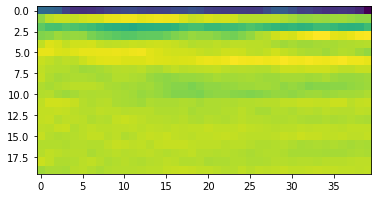

In [ ]:
plt.imshow(xTrain[2005].squeeze())

### define y

In [ ]:
# # encode classes
# le = preprocessing.LabelEncoder()
# le.fit(trainTBP.label.unique())
# yTrain = le.transform(trainTBP.label)
# yValid = le.transform(validTBP.label)
# yTest = le.transform(testTBP.label)

# print(le.classes_)

# yTrain = le.transform(trainTBP.label)
# yValid = le.transform(validTBP.label)
# yTest = le.transform(testTBP.label)

In [ ]:
labels = labels20 + ['other']

In [ ]:
encodedClasses = {labels[i]:i for i in range(len(labels))}

print(sorted(encodedClasses.items(), key=lambda item: item[1]))

[('go', 0), ('stop', 1), ('on', 2), ('off', 3), ('up', 4), ('down', 5), ('yes', 6), ('no', 7), ('left', 8), ('right', 9), ('zero', 10), ('one', 11), ('two', 12), ('three', 13), ('four', 14), ('five', 15), ('six', 16), ('seven', 17), ('eight', 18), ('nine', 19), ('other', 20)]


In [ ]:
yTrain = np.array(trainProc.label.replace(encodedClasses))
yValid = np.array(validProc.label.replace(encodedClasses))
yTest = np.array(testProc.label.replace(encodedClasses))

### Set last parameters

In [ ]:
inputShape = xTrain[0].shape # time, N_MELS (freq), 1
nClasses = len(labels)

print(f'inputShape={inputShape}, nClasses={nClasses}', flush=True)

inputShape=(38, 40, 1), nClasses=21


## 20 features

### no fmin/fmax

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [4,8] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history1 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

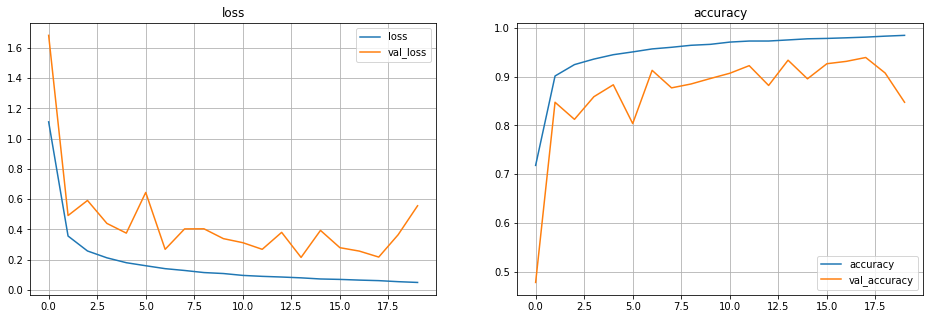

In [ ]:
plot_history(history1)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [8,16] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history2 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        8256      
_________________________________________________________________
batch_normalization_20 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_20 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        131136    
_________________________________________________________________
batch_normalization_21 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_21 (Activation)   (None, 19, 20, 64)        0     

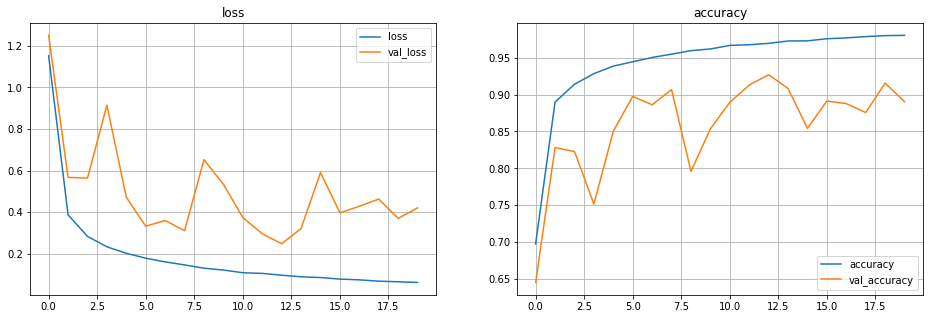

In [ ]:
plot_history(history2)

### fmin=55

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [4,8] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history4 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        2112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 40, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        131136    
_________________________________________________________________
batch_normalization_6 (Batch (None, 19, 20, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 19, 20, 64)        0     

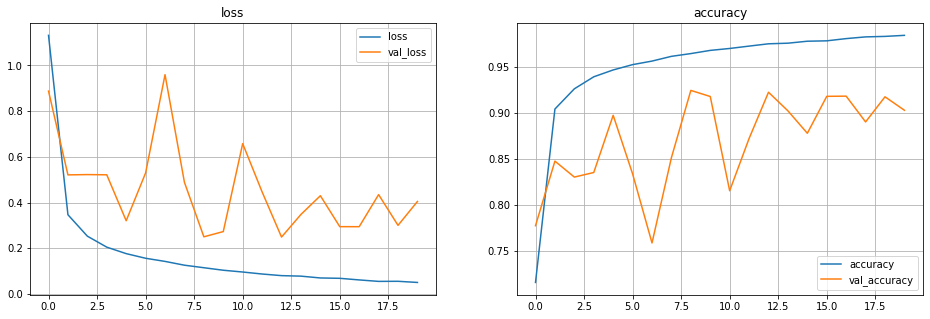

In [ ]:
plot_history(history4)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [8,16] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history5 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        8256      
_________________________________________________________________
batch_normalization_30 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        131136    
_________________________________________________________________
batch_normalization_31 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_31 (Activation)   (None, 19, 20, 64)        0     

KeyboardInterrupt: ignored

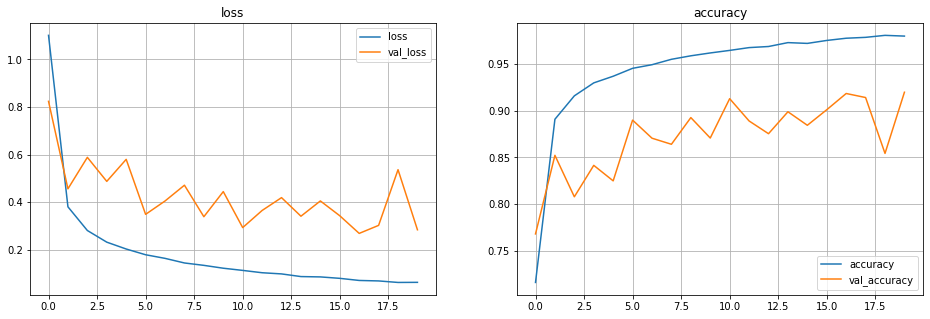

In [ ]:
plot_history(history5)

### fmin=55, fmax=1760

In [ ]:
# fmin=55, fmax=1760
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [4,8] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history5 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        2112      
_________________________________________________________________
batch_normalization_35 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_35 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        131136    
_________________________________________________________________
batch_normalization_36 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_36 (Activation)   (None, 19, 20, 64)        0     

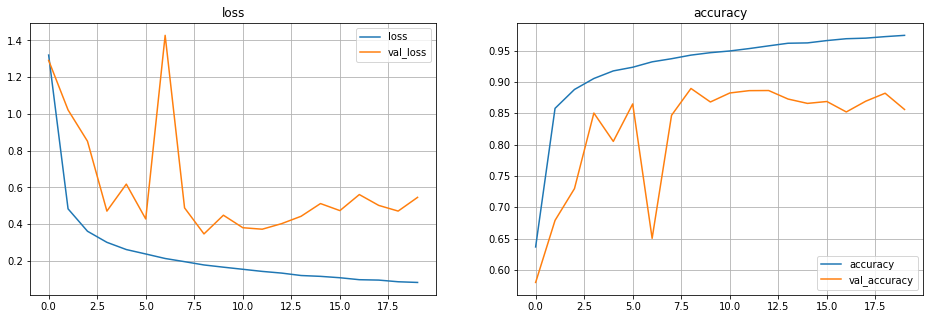

In [ ]:
plot_history(history5)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [8,16] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history6 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        8256      
_________________________________________________________________
batch_normalization_40 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_40 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        131136    
_________________________________________________________________
batch_normalization_41 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_41 (Activation)   (None, 19, 20, 64)        0     

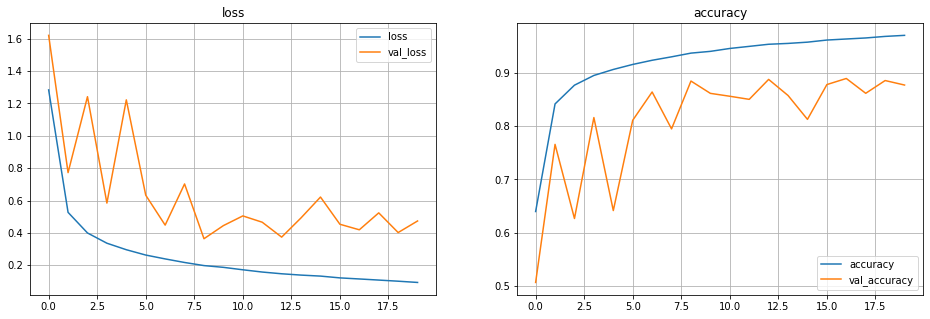

In [ ]:
plot_history(history6)

### fmin=55, fmax=1760, N_MELS=20 (two pooling layers removed)!

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [4,8] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history7 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 20, 64)        2112      
_________________________________________________________________
batch_normalization_55 (Batc (None, 38, 20, 64)        256       
_________________________________________________________________
activation_55 (Activation)   (None, 38, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 38, 20, 64)        131136    
_________________________________________________________________
batch_normalization_56 (Batc (None, 38, 20, 64)        256       
_________________________________________________________________
activation_56 (Activation)   (None, 38, 20, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 38, 20, 64)        32832 

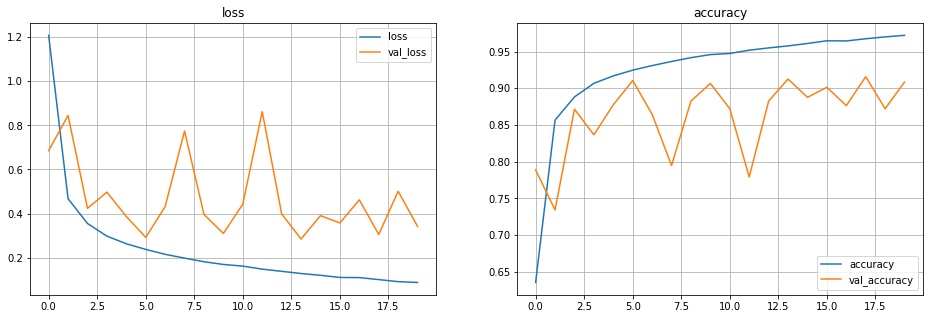

In [ ]:
plot_history(history7)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [8,16] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history8 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 20, 64)        8256      
_________________________________________________________________
batch_normalization_60 (Batc (None, 38, 20, 64)        256       
_________________________________________________________________
activation_60 (Activation)   (None, 38, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 38, 20, 64)        131136    
_________________________________________________________________
batch_normalization_61 (Batc (None, 38, 20, 64)        256       
_________________________________________________________________
activation_61 (Activation)   (None, 38, 20, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 38, 20, 64)        32832 

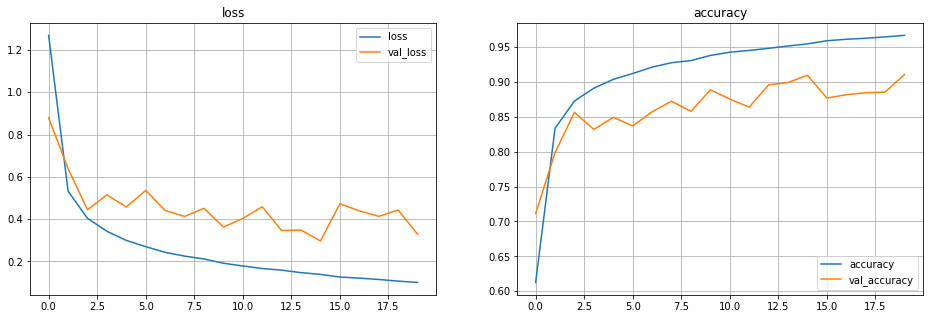

In [ ]:
plot_history(history8)

## 20 features + other

### NO - N_MELS = 30

#### fmin=55, fmax=1760, N_MELS=30 (one pooling layer removed)!

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [4,8] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history9 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 30, 64)        2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 30, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 38, 30, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 15, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 15, 64)        131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 15, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 19, 15, 64)        0     

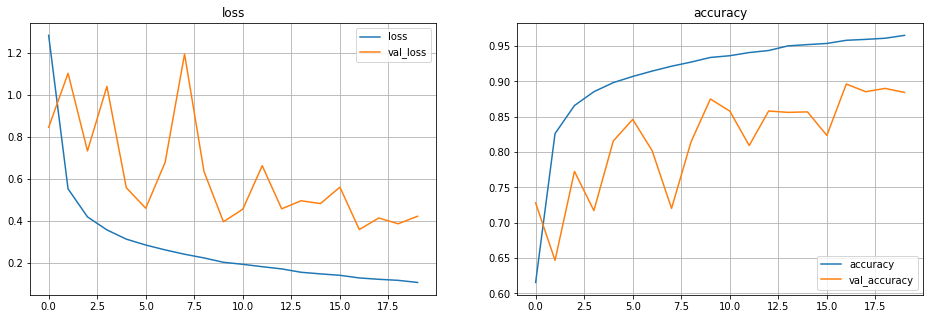

In [ ]:
plot_history(history9)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = [8,16] # input time x freq
kernelSize2 = [4,8]
kernelSize3 = [2,4]
kernelSize4 = [2,2]

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history10 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 30, 64)        8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 30, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 38, 30, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 15, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 15, 64)        131136    
_________________________________________________________________
batch_normalization_6 (Batch (None, 19, 15, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 19, 15, 64)        0     

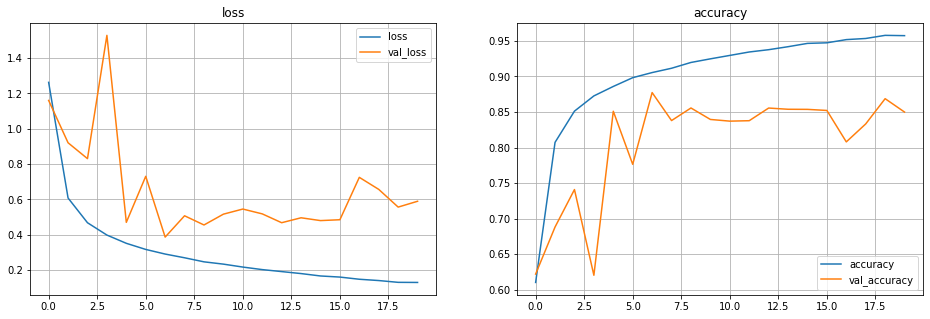

In [ ]:
plot_history(history10)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history11 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 30, 64)        4160      
_________________________________________________________________
batch_normalization_10 (Batc (None, 38, 30, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 38, 30, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 15, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 15, 64)        65600     
_________________________________________________________________
batch_normalization_11 (Batc (None, 19, 15, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 19, 15, 64)        0     

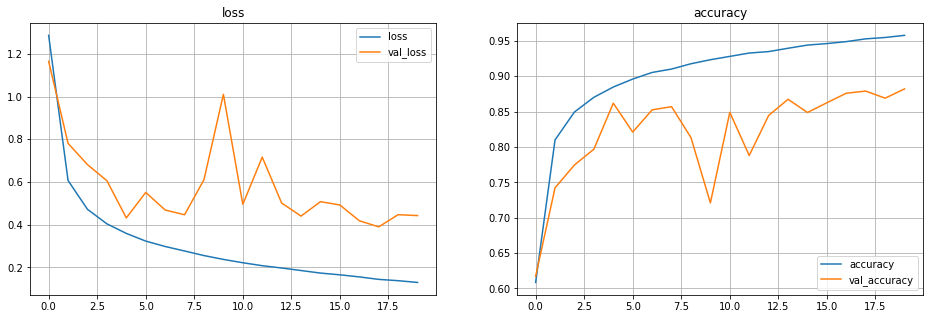

In [ ]:
plot_history(history11)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history12 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 30, 64)        4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 30, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 38, 30, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 15, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 15, 64)        65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 15, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 19, 15, 64)        0     

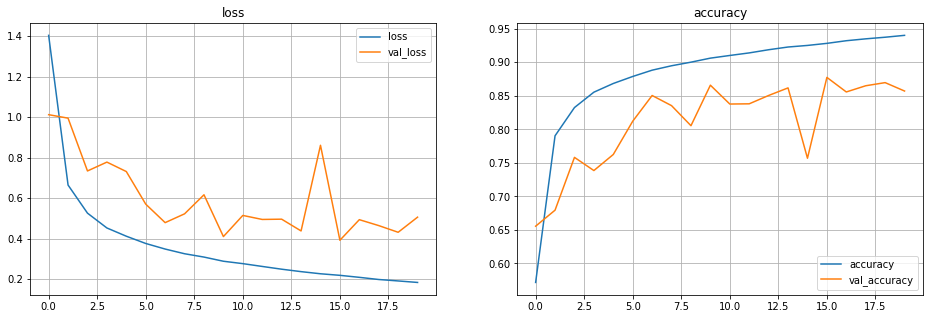

In [ ]:
plot_history(history12)

#### fmin=55, fmax=1760, N_MELS=30 (one pooling layer removed, added 0.01 regularization to all layers)

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history13 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 30, 64)        4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 30, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 38, 30, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 15, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 15, 64)        65600     
_________________________________________________________________
batch_normalization_6 (Batch (None, 19, 15, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 19, 15, 64)        0     

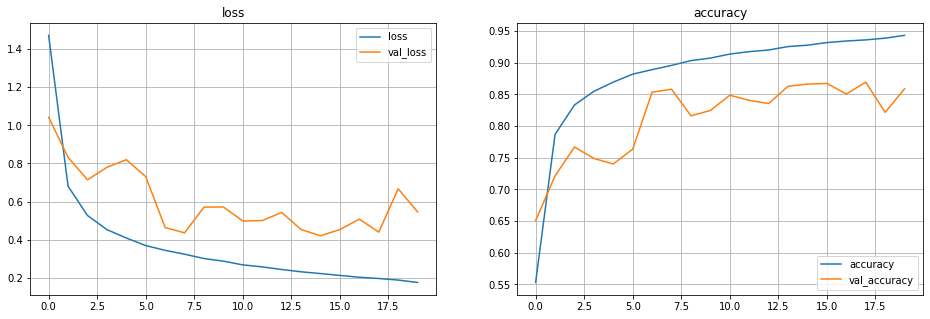

In [ ]:
plot_history(history13)

### N_MELS = 24

#### YES CNN model

In [ ]:
def CNN_small(inputShape, nClasses, nFilters1, nFilters2, nFilters3, nFilters4,
              kernelSize1, kernelSize2, kernelSize3, kernelSize4,
              poolSize, l2Reg):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling4'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN_small'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

#### NO fmin=55, fmax=1760, N_MELS=24 (one pooling layer removed)!

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history14 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 24, 64)        4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 24, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 38, 24, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 12, 64)        65600     
_________________________________________________________________
batch_normalization_6 (Batch (None, 19, 12, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 19, 12, 64)        0     

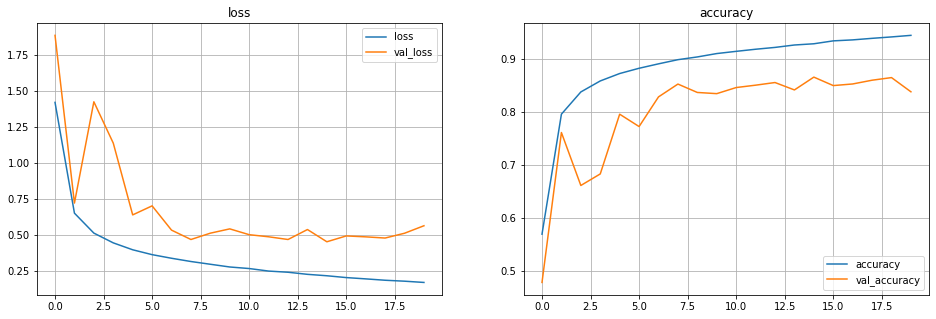

In [ ]:
plot_history(history14)

#### YES fmin=55, fmax=1760, N_MELS=24 (two pooling layers removed and one Conv layer removed)!

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history15 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 50, 24, 64)        4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 24, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 50, 24, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 25, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 25, 12, 64)        65600     
_________________________________________________________________
batch_normalization_8 (Batch (None, 25, 12, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 25, 12, 64)        0     

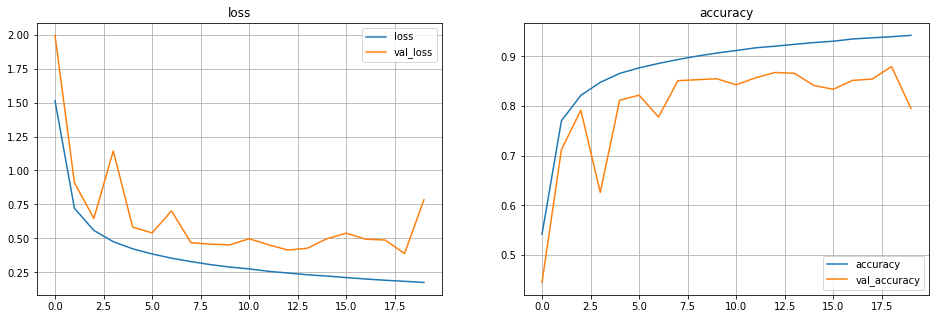

In [ ]:
plot_history(history15)

##### No pool

In [ ]:
def CNN_model_noPool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 8 ################################################################
kernelSize3 = 8 ################################################################
kernelSize4 = 8 ################################################################

poolSize = 2

model = CNN_model_noPool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history15noPool = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                            validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 50, 24, 64)        4160      
_________________________________________________________________
batch_normalization_15 (Batc (None, 50, 24, 64)        256       
_________________________________________________________________
activation_15 (Activation)   (None, 50, 24, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 50, 24, 64)        262208    
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 24, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 50, 24, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 50, 24, 64)        262208

In [ ]:
plot_history(history15noPool)

##### YES2 Same model, slightly smaller HOP_LEN (304 (0.019) vs 400 (0.025))

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history15smallerHOP = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 50, 24, 64)        4160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 24, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 50, 24, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 25, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 25, 12, 64)        65600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 12, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 25, 12, 64)        0     

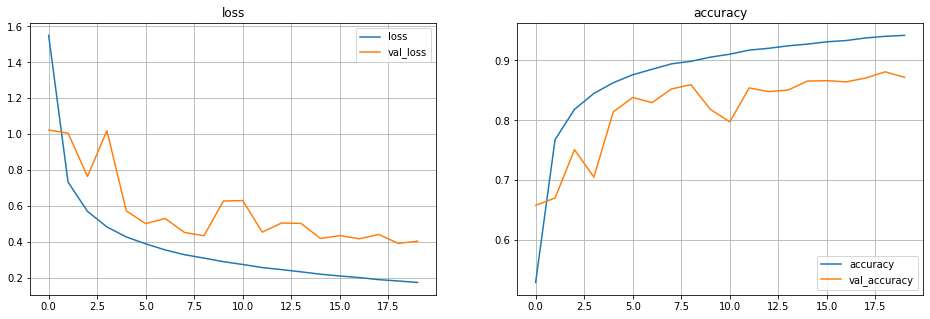

In [ ]:
plot_history(history15smallerHOP)

##### NO Same model, slightly smaller HOP_LEN (304 (0.019) vs 400 (0.025)) and one pooling more removed.

In [ ]:
def CNN_model_pool_red(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        # Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                        #        name='Conv2D_4',
                        #        kernel_regularizer = keras.regularizers.l2(0.0)),
                        # BatchNormalization(),
                        # Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 8 ####################
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool_red(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history15smallerHOPred = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 50, 24, 64)        4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 24, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 50, 24, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 25, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 25, 12, 64)        262208    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 12, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 12, 64)        0     

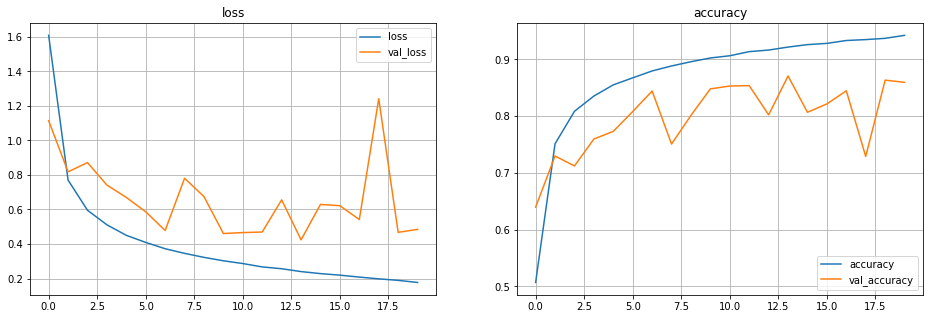

In [ ]:
plot_history(history15smallerHOPred)

#### NO Edited YES CNN model

In [ ]:
def CNN_model_pool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = as.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history15bis = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                         validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 24, 64)        4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 38, 24, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 38, 24, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 38, 24, 64)        65600     
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 24, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 38, 24, 64)        0         
_________________________________________________________________
AveragePooling2 (AveragePool (None, 19, 12, 64)        0     

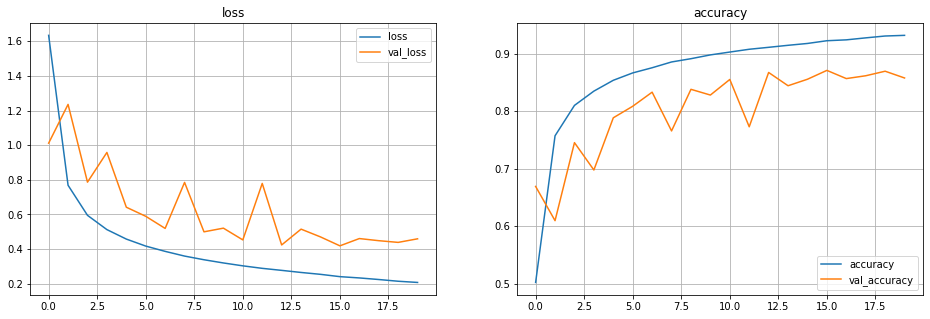

In [ ]:
plot_history(history15bis)

###### Pool position changes the number of mults but not the number of params (shared parameters, only dependent on the filter size!)

#### NO fmin=55, fmax=1760, N_MELS=24 (three pooling layers removed and two Conv layers removed)!

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history16 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 24, 64)        4160      
_________________________________________________________________
batch_normalization_18 (Batc (None, 38, 24, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 38, 24, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 12, 64)        65600     
_________________________________________________________________
batch_normalization_19 (Batc (None, 19, 12, 64)        256       
_________________________________________________________________
activation_19 (Activation)   (None, 19, 12, 64)        0     

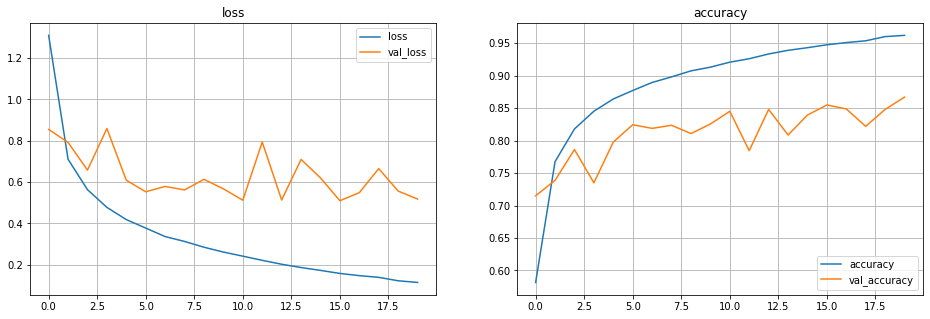

In [ ]:
plot_history(history16)

### NO - N_MFCC = 16 and 20 from 24 MELS

In [ ]:
def CNN_ultraSmall(inputShape, nClasses, nFilters1, nFilters2, nFilters3, nFilters4,
              kernelSize1, kernelSize2, kernelSize3, kernelSize4,
              poolSize, l2Reg):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = as.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(l2Reg)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling4'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN_small'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 32
nFilters2 = 32
nFilters3 = 32
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_ultraSmall(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2, l2Reg=0.0)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history25smallerHOP = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN_small"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 16, 24, 32)        2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 24, 32)        128       
_________________________________________________________________
activation_32 (Activation)   (None, 16, 24, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 16, 24, 32)        16416     
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 24, 32)        128       
_________________________________________________________________
activation_33 (Activation)   (None, 16, 24, 32)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 16, 24, 32)        92

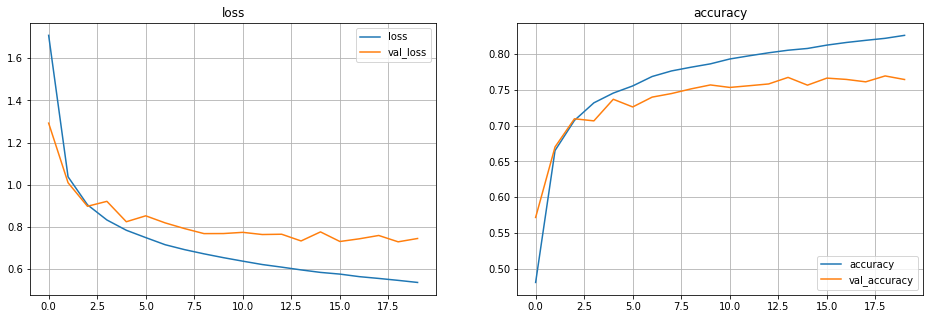

In [ ]:
plot_history(history25smallerHOP) # 32 32 32 16

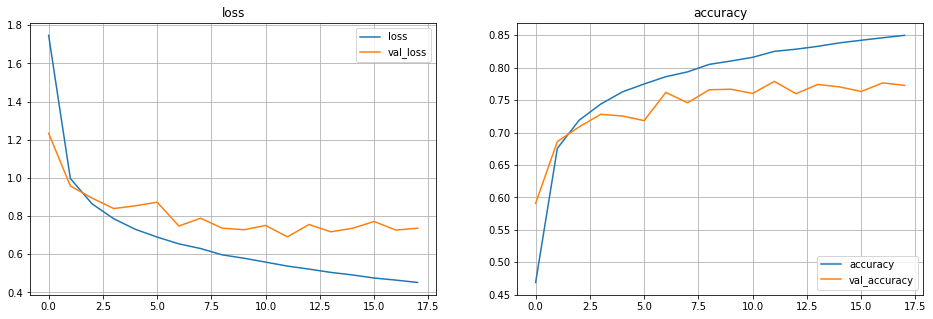

In [ ]:
plot_history(history25smallerHOP) # 32 64 64 16

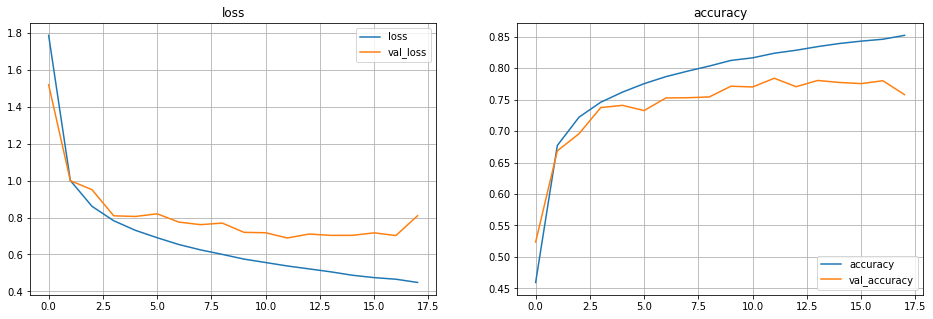

In [ ]:
plot_history(history25smallerHOP) # 64 64 64 16

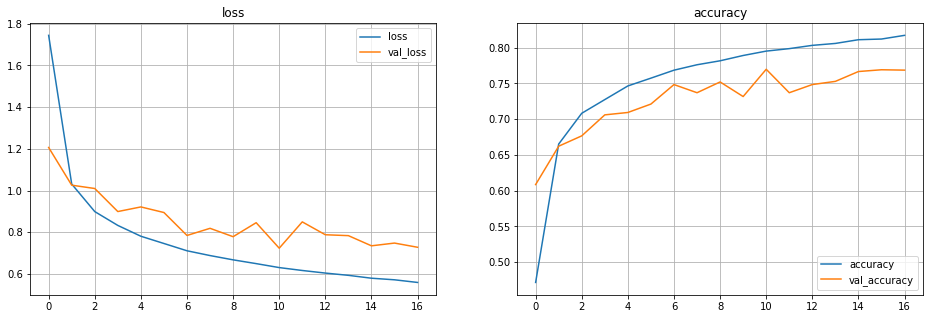

In [ ]:
plot_history(history25smallerHOP) # 32 32 32 16, 20 MFCC

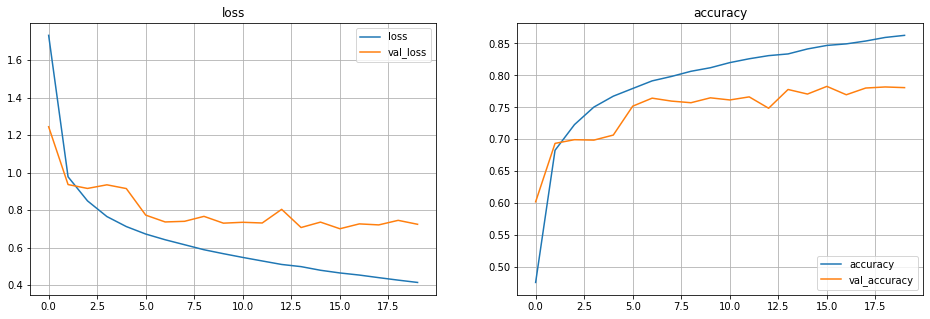

In [ ]:
plot_history(history25smallerHOP) # 32 64 64 16, 20 MFCC

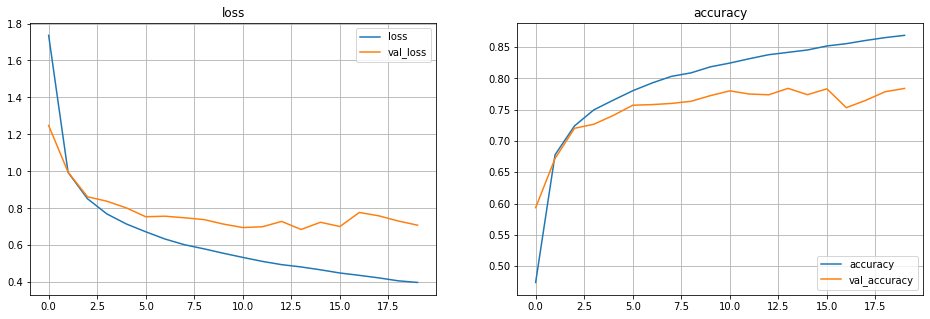

In [ ]:
plot_history(history25smallerHOP) # 64 64 64 16, 20 MFCC

### N_MELS = 40

#### CNN model

In [ ]:
def CNN_model_pool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

#### YES CNN model from 24 MELS task... does it work? Gne

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history50 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 38, 40, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_9 (Batch (None, 19, 20, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 19, 20, 64)        0     

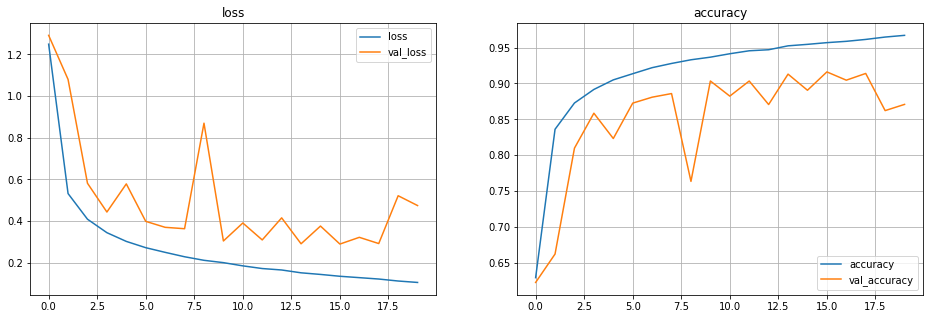

In [ ]:
plot_history(history50)

#### YES CNN model from 24 MELS task with moved pool size - NIENTE MALE

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history51 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        4160      
_________________________________________________________________
batch_normalization_40 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_40 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_41 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_41 (Activation)   (None, 19, 20, 64)        0     

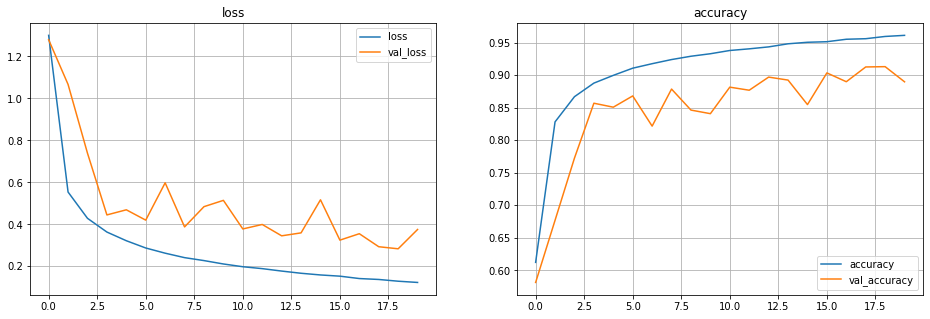

In [ ]:
plot_history(history51)

#### YES CNN model from 24 MELS task with 64 filters in the last layer - MEGLIO 32

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 64 ############################################

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history52 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        4160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 38, 40, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_5 (Batch (None, 19, 20, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 19, 20, 64)        0     

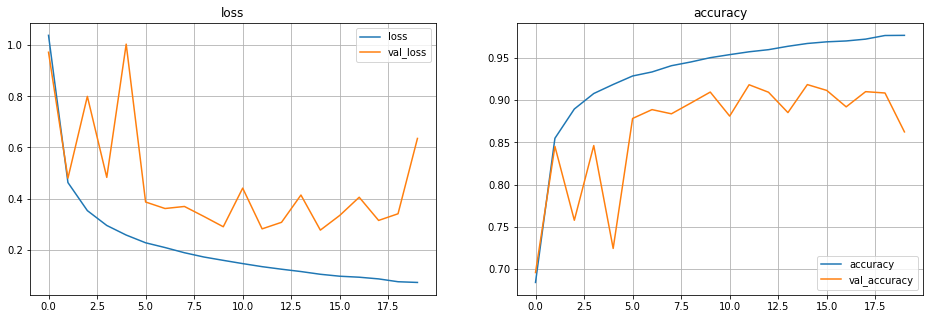

In [ ]:
plot_history(history52)

#### YES CNN model from 24 MELS task with 8 filters in the last layer NO

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 8 ##############################################

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

history53 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 38, 40, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_9 (Batch (None, 19, 20, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 19, 20, 64)        0     

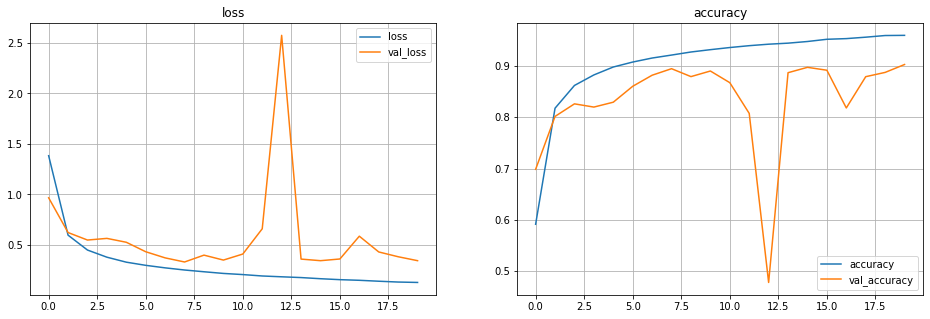

In [ ]:
plot_history(history53)

#### YES CNN model from 24 MELS task with 32 filters in the last layer and a different first filter size - NIENTE MALE

GS over kernel1 shape (6/8,30/32), kernel 2 shape(?), regularization (0,0.05), pool size(? 2,3?), BS 128/256

In [ ]:
def CNN_model_pool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 32 ##############################################

kernelSize1 = [6, 32] # input time x freq ################### [8, 32] sotto, [8, 16], [13, 13], [20, 20] peggiori
# [4, 32] non male, [2, 32] e [1, 32] peggio
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history54 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        12352     
_________________________________________________________________
batch_normalization_44 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_45 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_45 (Activation)   (None, 19, 20, 64)        0     

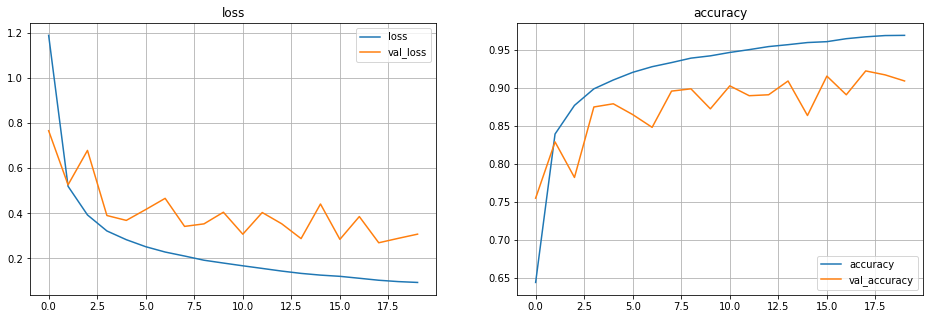

In [ ]:
# new one
plot_history(history54)

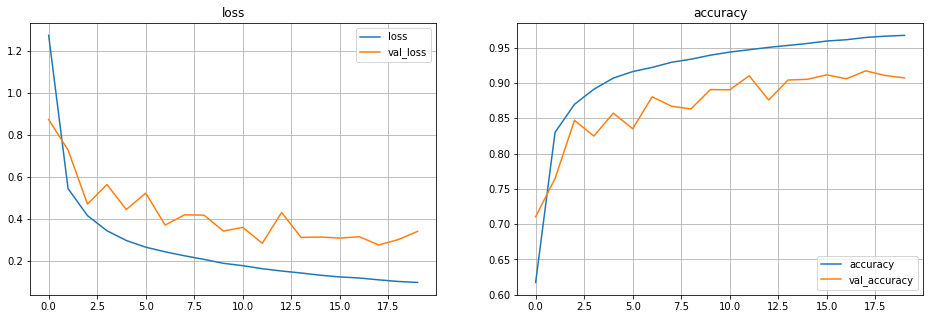

In [ ]:
plot_history(history54)

##### TEST SET test

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 32 ##############################################

kernelSize1 = [8, 32] # input time x freq ###################
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history54test = model.fit(np.concatenate([xTrain,xValid], axis=0), np.concatenate([yTrain,yValid], axis=0), epochs=nEpochs, batch_size=batchSize,
                          validation_data=(xTest, yTest), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        16448     
_________________________________________________________________
batch_normalization_52 (Batc (None, 38, 40, 64)        256       
_________________________________________________________________
activation_52 (Activation)   (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_53 (Batc (None, 19, 20, 64)        256       
_________________________________________________________________
activation_53 (Activation)   (None, 19, 20, 64)        0     

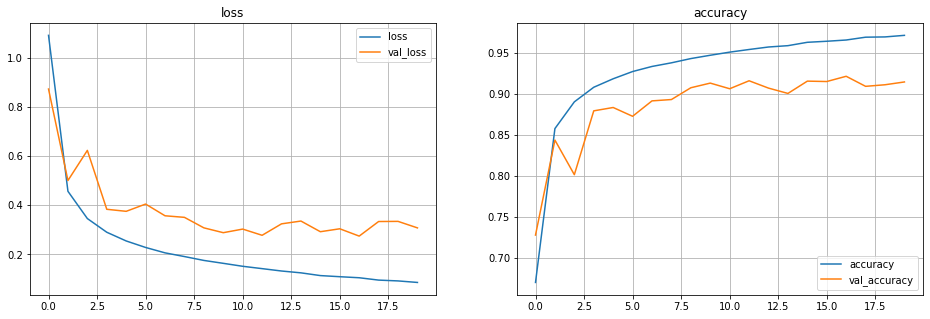

In [ ]:
plot_history(history54test)

#### YES CNN model from 24 MELS task with 32 filters in the last layer and a different first filter size NO POOLING ASSOLUTAMENTE NO

In [ ]:
def CNN_model_noPool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="valid",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="valid",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="valid",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="valid",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.1)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 32 ##############################################

kernelSize1 = [8, 16] # input time x freq ###################
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_noPool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history55 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 31, 25, 64)        8256      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 25, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 31, 25, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 28, 22, 64)        65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 22, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 22, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 26, 20, 64)        36928 

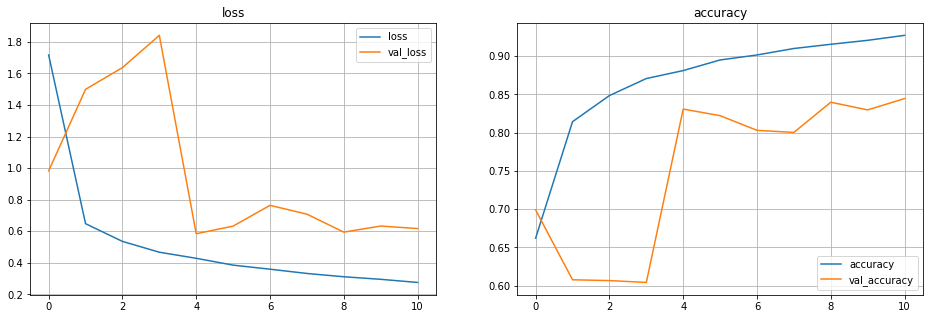

In [ ]:
plot_history(history55)

### YES - N_MFCC = 20 from 40 MELS

In [ ]:
def CNN_model_medium(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 6
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_medium(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history150 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 20, 40, 64)        2368      
_________________________________________________________________
batch_normalization_68 (Batc (None, 20, 40, 64)        256       
_________________________________________________________________
activation_68 (Activation)   (None, 20, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 10, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 10, 20, 64)        65600     
_________________________________________________________________
batch_normalization_69 (Batc (None, 10, 20, 64)        256       
_________________________________________________________________
activation_69 (Activation)   (None, 10, 20, 64)        0     

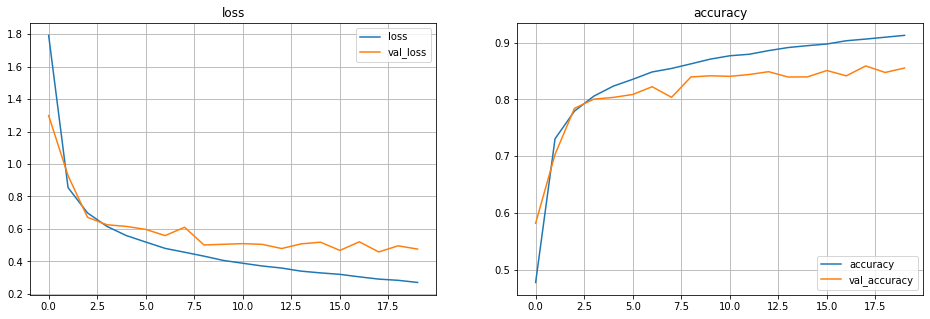

In [ ]:
plot_history(history150) # first layer 64 16x16 filters

###### yes

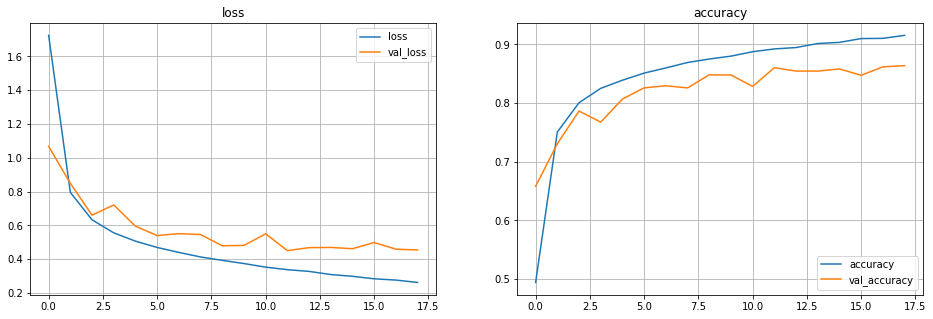

In [ ]:
plot_history(history150) # first layer 64 8x8 filters

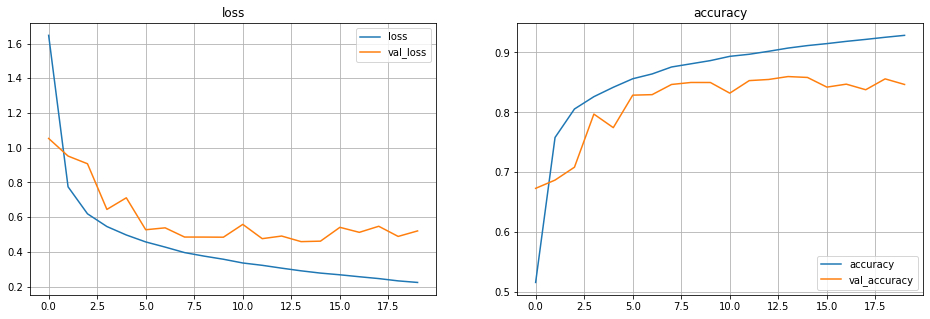

In [ ]:
plot_history(history150) # first layer 64 6x6 filters

### NO N_MELS = 64

#### CNN model

In [ ]:
def CNN_model_pool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="same",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="same",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="same",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="same",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )

    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

#### YES CNN model from 24 MELS task... does it work?

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 16

kernelSize1 = 8 # input time x freq
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = 2

model = CNN_model_pool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history70 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

Model: "CNN2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 38, 40, 64)        4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 38, 40, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 38, 40, 64)        0         
_________________________________________________________________
AveragePooling1 (AveragePool (None, 19, 20, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 19, 20, 64)        65600     
_________________________________________________________________
batch_normalization_9 (Batch (None, 19, 20, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 19, 20, 64)        0     

In [ ]:
plot_history(history70)

#### YES CNN model from 24 MELS task with 32 filters in the last layer and a different first filter size NO POOLING

In [ ]:
def CNN_model_noPool(inputShape, nClasses, nFilters1=64, nFilters2=64, nFilters3=64, nFilters4=64, nFilters5=64,
              kernelSize1=[9,4], kernelSize2=[3,3], kernelSize3=[3,3], kernelSize4=[3,3],
              poolSize=2):

    model = Sequential([
                        Conv2D(filters=nFilters1, kernel_size=kernelSize1, padding="valid",
                               name='Conv2D_1', input_shape=inputShape,
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling1'),
                        Conv2D(filters=nFilters2, kernel_size=kernelSize2, padding="valid",
                               name='Conv2D_2',
                               kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling2'),
                        Conv2D(filters=nFilters3, kernel_size=kernelSize3, padding="valid",
                               name='Conv2D_3', kernel_regularizer = keras.regularizers.l2(0.0)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling3'),
                        Conv2D(filters=nFilters4, kernel_size=kernelSize4, padding="valid",
                               name='Conv2D_4',
                               kernel_regularizer = keras.regularizers.l2(0.1)),
                        BatchNormalization(),
                        Activation('relu'),
                        # AveragePooling2D(pool_size=poolSize, name='AveragePooling5'),
                        Flatten(),
                        Dense(nClasses, activation='softmax', name='classification')
                        ], name='CNN2D'
    )
    
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    print(model.summary(), flush=True)

    return model

In [ ]:
nFilters1 = 64
nFilters2 = 64
nFilters3 = 64
nFilters4 = 32 ##############################################

kernelSize1 = 8 # input time x freq ###################
kernelSize2 = 4
kernelSize3 = 3
kernelSize4 = 2

poolSize = [1, 2]

model = CNN_model_noPool(inputShape=inputShape, nClasses=nClasses,
                  nFilters1=nFilters1, nFilters2=nFilters2, nFilters3=nFilters3, nFilters4=nFilters4,
                  kernelSize1=kernelSize1, kernelSize2=kernelSize2, kernelSize3=kernelSize3, kernelSize4=kernelSize4,
                  poolSize=2)

nEpochs = 20
batchSize = 128

# in Keras the early stopping is managed by using the callbacks argument.
callbacks = [
             keras.callbacks.TensorBoard('./TensorBoard/'),
             keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
             # Saving the checkpoints file allows to load the "best" model when the Early
             # stopping detect that the generalization error degrade (after 'patience' epochs)
             keras.callbacks.ModelCheckpoint("cnnModel.h5", save_best_only=True),
             ]

history71 = model.fit(xTrain, yTrain, epochs=nEpochs, batch_size=batchSize,
                     validation_data=(xValid, yValid), shuffle=True, callbacks=callbacks)

In [ ]:
plot_history(history71)

## Results exploration

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

def print_results(y_true, y_pred):

    confusion = confusion_matrix(y_true, y_pred)
    
    _ = plt.figure(figsize=(10,10))
    sns.heatmap(confusion, annot=True, annot_kws={"size": 8}) # font size
    plt.show()

    print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_true, y_pred)))

    print('Micro Precision: {:.4f}'.format(precision_score(y_true, y_pred, average='micro')))
    print('Micro Recall: {:.4f}'.format(recall_score(y_true, y_pred, average='micro')))
    print('Micro F1-score: {:.4f}\n'.format(f1_score(y_true, y_pred, average='micro')))

    print('Macro Precision: {:.4f}'.format(precision_score(y_true, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_true, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_true, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_true, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
labels[0], labels[14]

('go', 'four')

Confusion Matrix



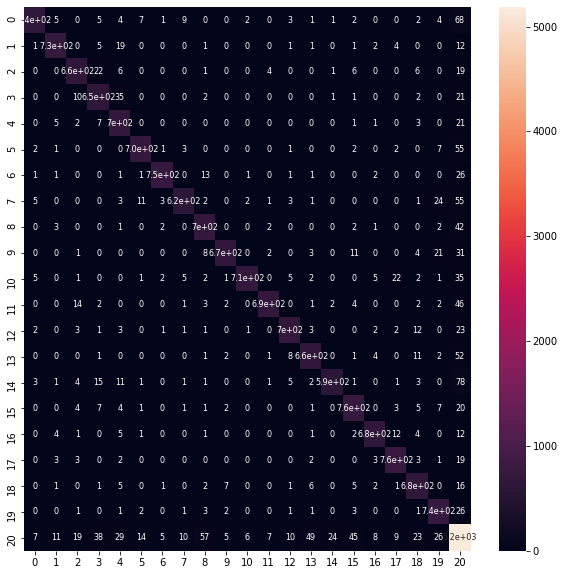


Accuracy: 0.9148

Micro Precision: 0.9148
Micro Recall: 0.9148
Micro F1-score: 0.9148

Macro Precision: 0.9267
Macro Recall: 0.9103
Macro F1-score: 0.9173

Weighted Precision: 0.9172
Weighted Recall: 0.9148
Weighted F1-score: 0.9150

Classification Report

              precision    recall  f1-score   support

          go       0.96      0.85      0.90       753
        stop       0.95      0.94      0.95       773
          on       0.91      0.91      0.91       728
         off       0.86      0.90      0.88       726
          up       0.84      0.95      0.89       737
        down       0.95      0.91      0.93       779
         yes       0.98      0.94      0.96       798
          no       0.95      0.85      0.90       732
        left       0.88      0.93      0.90       757
       right       0.97      0.89      0.93       752
        zero       0.98      0.89      0.93       797
         one       0.97      0.90      0.93       771
         two       0.95      0.93      

In [ ]:
print_results(yTest, np.argmax(model.predict(xTest), axis=1))